# XGBoost Classifier and LightGBM Classifier
XGBoost Classifier and LightGBM Classifier are popular tree-based boosting models that can learn the more complex relationships between the data as compared to our linear benchmark models. It may prove advantageous to employ more complex models such as XGBoost and LightGBM that reduce bias but increase variance since the increase in variance is countered by the lower variance brought about by the relatively sizable dataset size. Furthermore, both models were implemented due to their different learning algorithms. XGBoost learns level-wise, while LightGBM learns leaf-wise, alluding that while LightGBM may be more prone to overfitting compared to XGBoost‌, it may potentially outperform XGBoost if proper regularisation is executed. Hence, a comparison between the two boosting models will be meaningful in optimising performance.

Similar to Random Forest, the innate feature importance scores of these tree-based models were utilised for feature selection. Using the feature importance scores obtained from the trained model, `SelectFromModel` from scikit-learn is employed to retain all features with scores above the median.
Moreover, our initial evaluation where all our models were trained and validated on the dataset with all our features highlighted the promising results of XGBoost and LightGBM. Therefore, more experimentation was implemented for the two models.

While all dataset variants will be fitted on these two tree-based models and tuned with RandomizedSearchCV instead of GridSearchCV due to limited computational resources and to prevent overfitting, dataset variants that have not undergone feature selection prior, $X\_train\_without\_missing$ and $X\_train\_with\_embeddings$, will undergo feature selection utilising the feature importance scores of the tree-based models and via RFECV. The models are fitted to the two abovementioned datasets and feature selection using the feature importance scores is carried out, with hyperparameter tuning executed after. Carrying out feature selection after the model is tuned may improve model performance due to the tuned model plausibly learning the complex relationships of the data better and hence, able to output more accurate feature importance scores. RFECV is employed as an alternative feature selection method to using the feature importance scores of tree-based models. XGBoost and LightGBM have 20 model variants each, including tuned and untuned models, to determine the most optimal dataset, hyperparameters and features when predicting the validation set.

# Import Libraries and Read Data

In [ ]:
import pandas as pd
import seaborn as sns
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
import joblib

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance


from sklearn.feature_selection import RFECV, SelectFromModel ## use of RFECV when training models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## All features

In [ ]:
X_train = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_train_without_missing.xlsx")
X_val = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_val_without_missing.xlsx")
X_test = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_test_without_missing.xlsx")

In [ ]:
y_train = pd.read_excel("/content/drive/My Drive/dsa4266_data/y_train.xlsx")
y_val =  pd.read_excel("/content/drive/My Drive/dsa4266_data/y_val.xlsx")
y_test = pd.read_excel("/content/drive/My Drive/dsa4266_data/y_test.xlsx")

In [ ]:
y_train = y_train['status']
y_val = y_val['status']


In [ ]:
y_test = y_test['status']

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(7968, 79) (7968,) (1708, 79) (1708,) (1708, 79) (1708,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 79 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7968 non-null   int64  
 1   url                         7968 non-null   object 
 2   length_hostname             7968 non-null   float64
 3   ip                          7968 non-null   int64  
 4   nb_dots                     7968 non-null   float64
 5   nb_hyphens                  7968 non-null   float64
 6   nb_at                       7968 non-null   float64
 7   nb_qm                       7968 non-null   float64
 8   nb_and                      7968 non-null   float64
 9   nb_underscore               7968 non-null   float64
 10  nb_tilde                    7968 non-null   int64  
 11  nb_percent                  7968 non-null   float64
 12  nb_slash                    7968 non-null   float64
 13  nb_star                     7968 

In [ ]:
X_train.head(5)

,Unnamed: 0,url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_underscore,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,words_raw
0,5335,http://www.slideserve.com/yoshe/protein-domain...,0.355381,0,0.043478,0.069767,0.0,0.0,0.0,0.0,...,1,0,0,0.669891,0.888616,0.491812,0,0,0.5,"['slideserve', 'yoshe', 'protein', 'domain', '..."
1,5053,https://twitter.com/foxwoodsct,0.233052,0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,0.504719,0.942776,0.256847,0,0,1.0,"['twitter', 'foxwoodsct']"
2,8017,http://www.thefreedictionary.com/Indianapolis,0.438877,0,0.043478,0.000000,0.0,0.0,0.0,0.0,...,1,1,0,0.759904,0.923805,0.403067,0,0,0.6,"['thefreedictionary', 'indianapolis', 'www']"
3,5834,https://www.dialo.de/blog,0.254360,0,0.043478,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0.000000,0.856951,0.929275,0,0,0.4,"['dialo', 'blog', 'www']"
4,756,http://user67509874097802.el.r.appspot.com/wp-...,0.525505,1,0.130435,0.023256,0.0,0.0,0.0,0.0,...,1,1,0,0.527557,0.912333,0.000000,0,1,0.5,"['appspot', 'wp', 'content', 'user675098740978..."


In [ ]:
# drop words_raw
X_train = X_train.drop(columns = ['Unnamed: 0', 'url','words_raw'])
X_val = X_val.drop(columns = ['Unnamed: 0','url','words_raw'])
X_test = X_test.drop(columns = ['Unnamed: 0','url','words_raw'])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   length_hostname             7968 non-null   float64
 1   ip                          7968 non-null   int64  
 2   nb_dots                     7968 non-null   float64
 3   nb_hyphens                  7968 non-null   float64
 4   nb_at                       7968 non-null   float64
 5   nb_qm                       7968 non-null   float64
 6   nb_and                      7968 non-null   float64
 7   nb_underscore               7968 non-null   float64
 8   nb_tilde                    7968 non-null   int64  
 9   nb_percent                  7968 non-null   float64
 10  nb_slash                    7968 non-null   float64
 11  nb_star                     7968 non-null   int64  
 12  nb_colon                    7968 non-null   float64
 13  nb_comma                    7968 

## ANOVA features

In [ ]:
X_train_anova = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_train_ANOVA.xlsx")
X_val_anova = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_val_ANOVA.xlsx")
X_test_anova = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_test_ANOVA.xlsx")

In [ ]:
print(X_train_anova.shape, X_val_anova.shape, X_test_anova.shape, y_val.shape, X_test.shape, y_test.shape)

(7968, 33) (1708, 33) (1708, 33) (1708,) (1708, 76) (1708, 2)


In [ ]:
X_train_anova.head(5)

,Unnamed: 0,length_hostname,ip,nb_dots,nb_qm,nb_and,nb_slash,nb_www,nb_com,ratio_digits_url,...,empty_title,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,web_traffic,google_index,page_rank,url,words_raw
0,5335,0.355381,0,0.043478,0.0,0.0,0.064516,0.5,0.0,0.00000,...,0,1,0,0.669891,0.888616,0.491812,0,0.5,http://www.slideserve.com/yoshe/protein-domain...,"['slideserve', 'yoshe', 'protein', 'domain', '..."
1,5053,0.233052,0,0.000000,0.0,0.0,0.032258,0.0,0.0,0.00000,...,1,1,0,0.504719,0.942776,0.256847,0,1.0,https://twitter.com/foxwoodsct,"['twitter', 'foxwoodsct']"
2,8017,0.438877,0,0.043478,0.0,0.0,0.032258,0.5,0.0,0.00000,...,0,1,1,0.759904,0.923805,0.403067,0,0.6,http://www.thefreedictionary.com/Indianapolis,"['thefreedictionary', 'indianapolis', 'www']"
3,5834,0.254360,0,0.043478,0.0,0.0,0.032258,0.5,0.0,0.00000,...,0,0,0,0.000000,0.856951,0.929275,0,0.4,https://www.dialo.de/blog,"['dialo', 'blog', 'www']"
4,756,0.525505,1,0.130435,0.0,0.0,0.032258,0.0,0.0,0.36491,...,0,1,1,0.527557,0.912333,0.000000,1,0.5,http://user67509874097802.el.r.appspot.com/wp-...,"['appspot', 'wp', 'content', 'user675098740978..."


In [ ]:

X_train_anova = X_train_anova.drop(columns=['Unnamed: 0','url','words_raw'])
X_val_anova = X_val_anova.drop(columns=['Unnamed: 0','url','words_raw'])
X_test_anova = X_test_anova.drop(columns=['Unnamed: 0','url','words_raw'])

In [ ]:
X_train_anova.head(5)

,length_hostname,ip,nb_dots,nb_qm,nb_and,nb_slash,nb_www,nb_com,ratio_digits_url,ratio_digits_host,...,ratio_intMedia,safe_anchor,empty_title,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,web_traffic,google_index,page_rank
0,0.355381,0,0.043478,0.0,0.0,0.064516,0.5,0.0,0.00000,0.0,...,1.0,0.700000,0,1,0,0.669891,0.888616,0.491812,0,0.5
1,0.233052,0,0.000000,0.0,0.0,0.032258,0.0,0.0,0.00000,0.0,...,0.0,0.000000,1,1,0,0.504719,0.942776,0.256847,0,1.0
2,0.438877,0,0.043478,0.0,0.0,0.032258,0.5,0.0,0.00000,0.0,...,1.0,0.533333,0,1,1,0.759904,0.923805,0.403067,0,0.6
3,0.254360,0,0.043478,0.0,0.0,0.032258,0.5,0.0,0.00000,0.0,...,0.0,0.833333,0,0,0,0.000000,0.856951,0.929275,0,0.4
4,0.525505,1,0.130435,0.0,0.0,0.032258,0.0,0.0,0.36491,0.5,...,0.2,0.250000,0,1,1,0.527557,0.912333,0.000000,1,0.5


## Dataset with Embeddings

In [ ]:
X_train_emb = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_train_with_embeddings.xlsx")
X_val_emb = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_val_with_embeddings.xlsx")
X_test_emb = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_test_with_embeddings.xlsx")

In [ ]:
X_train_emb.columns = X_train_emb.columns.astype(str)
X_val_emb.columns = X_val_emb.columns.astype(str)
X_test_emb.columns = X_test_emb.columns.astype(str)

In [ ]:
X_train_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Columns: 503 entries, Unnamed: 0 to 423
dtypes: float64(469), int64(32), object(2)
memory usage: 30.6+ MB


In [ ]:
X_train_emb.head(5)

,Unnamed: 0,url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_underscore,...,414,415,416,417,418,419,420,421,422,423
0,0,http://www.slideserve.com/yoshe/protein-domain...,0.355381,0,0.043478,0.069767,0.0,0.0,0.0,0.0,...,0.836587,1.495418,2.990616,-5.242281,3.699764,3.784432,2.198872,-5.764069,1.846149,5.090627
1,1,https://twitter.com/foxwoodsct,0.233052,0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,2.478538,-3.004948,1.874929,2.510044,0.560954,-0.925629,0.422512,0.771005
2,2,http://www.thefreedictionary.com/Indianapolis,0.438877,0,0.043478,0.000000,0.0,0.0,0.0,0.0,...,2.540199,1.973463,1.326451,-1.742035,1.237872,1.667880,2.198872,-5.764069,1.846149,5.090627
3,3,https://www.dialo.de/blog,0.254360,0,0.043478,0.000000,0.0,0.0,0.0,0.0,...,0.784821,1.578395,4.316527,-4.370268,2.715998,3.938316,2.198872,-5.764069,1.846149,5.090627
4,4,http://user67509874097802.el.r.appspot.com/wp-...,0.525505,1,0.130435,0.023256,0.0,0.0,0.0,0.0,...,0.462385,1.528626,2.859798,-2.150408,0.991724,6.151215,2.351270,-4.198765,1.367338,5.120743


In [ ]:

X_train_emb = X_train_emb.drop(columns=['Unnamed: 0','url','words_raw'])
X_val_emb = X_val_emb.drop(columns=['Unnamed: 0','url','words_raw'])
X_test_emb = X_test_emb.drop(columns=['Unnamed: 0','url','words_raw'])

In [ ]:
X_train_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Columns: 500 entries, length_hostname to 423
dtypes: float64(469), int64(31)
memory usage: 30.4 MB


## Dataset with Encodings

In [ ]:
X_train_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_train_encoded.xlsx")
X_val_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_val_encoded.xlsx")
X_test_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_test_encoded.xlsx")

In [ ]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7968 non-null   int64  
 1   0           7968 non-null   float64
 2   1           7968 non-null   float64
 3   2           7968 non-null   float64
 4   3           7968 non-null   float64
 5   4           7968 non-null   float64
 6   5           7968 non-null   float64
 7   6           7968 non-null   float64
 8   7           7968 non-null   float64
 9   8           7968 non-null   float64
 10  9           7968 non-null   float64
 11  10          7968 non-null   float64
 12  11          7968 non-null   float64
 13  12          7968 non-null   float64
 14  13          7968 non-null   float64
 15  14          7968 non-null   float64
 16  15          7968 non-null   float64
dtypes: float64(16), int64(1)
memory usage: 1.0 MB


In [ ]:

X_train_encoded.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0.305295,0.536681,0.336594,0.442319,0.429356,0.177889,0.698409,0.432622,0.228868,0.340805,0.334690,0.302225,0.451098,0.551078,0.609543,0.231418
1,1,0.081153,0.321383,0.592065,0.211866,0.302116,0.335742,0.197140,0.748983,0.378946,0.280957,0.316813,0.258320,0.504553,0.493709,0.175500,0.075103
2,2,0.235573,0.442604,0.412183,0.443087,0.425432,0.381638,0.755711,0.386666,0.284873,0.312074,0.418234,0.274837,0.480701,0.732669,0.647266,0.178862
3,3,0.192484,0.300707,0.388996,0.582032,0.209292,0.053646,0.375167,0.541650,0.311723,0.282957,0.201249,0.000000,0.439634,0.150557,0.335622,0.295943
4,4,0.692275,0.398863,0.442169,0.364417,0.587399,0.667282,0.458261,0.156895,0.583693,0.333708,0.703519,0.526451,0.559017,0.777086,0.638569,0.262517


In [ ]:
X_train_encoded = X_train_encoded.drop(columns = ['Unnamed: 0'])
X_val_encoded = X_val_encoded.drop(columns = ['Unnamed: 0'])
X_test_encoded = X_test_encoded.drop(columns = ['Unnamed: 0'])

## Dataset with Embeddings + Encoded

In [ ]:
X_train_emb_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_train_embeddings_encoded.xlsx")
X_val_emb_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_val_embeddings_encoded.xlsx")
X_test_emb_encoded = pd.read_excel("/content/drive/My Drive/dsa4266_data/X_test_embeddings_encoded.xlsx")

In [ ]:
X_train_emb_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7968 non-null   int64  
 1   0           7968 non-null   int64  
 2   1           7968 non-null   float64
 3   2           7968 non-null   float64
 4   3           7968 non-null   float64
 5   4           7968 non-null   float64
 6   5           7968 non-null   float64
 7   6           7968 non-null   float64
 8   7           7968 non-null   float64
 9   8           7968 non-null   float64
 10  9           7968 non-null   float64
 11  10          7968 non-null   float64
 12  11          7968 non-null   float64
 13  12          7968 non-null   float64
 14  13          7968 non-null   float64
 15  14          7968 non-null   int64  
 16  15          7968 non-null   float64
 17  16          7968 non-null   float64
 18  17          7968 non-null   float64
 19  18          7968 non-null  

In [ ]:
X_train_emb_encoded.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,0,0,0.222941,0.084212,0.092293,0.262575,0.312153,0.106745,0.378524,0.117959,...,0.053810,0.137103,0.392034,0.353246,0.619004,0.224303,0.124723,0.154050,0.420779,0.058250
1,1,0,0.256436,0.161667,0.260177,0.237586,0.064205,0.270275,0.391214,0.062966,...,0.014128,0.137107,0.472954,0.201257,0.103128,0.240759,0.022675,0.162383,0.576599,0.076394
2,2,0,0.231051,0.168364,0.256087,0.206718,0.058760,0.172887,0.322137,0.042456,...,0.041530,0.161529,0.284827,0.109305,0.379360,0.376608,0.154480,0.254852,0.466095,0.067020
3,3,0,0.238879,0.223776,0.153920,0.128237,0.129961,0.089479,0.375713,0.131082,...,0.025098,0.149871,0.295254,0.063282,0.376610,0.381413,0.089592,0.213751,0.541623,0.011707
4,4,0,0.290910,0.212934,0.167230,0.245797,0.385485,0.117408,0.277093,0.241747,...,0.043226,0.069421,0.700623,0.624933,0.585502,0.467500,0.309404,0.085110,0.020485,0.137365


In [ ]:
X_train_emb_encoded = X_train_emb_encoded.drop(columns = ['Unnamed: 0'])
X_val_emb_encoded = X_val_emb_encoded.drop(columns = ['Unnamed: 0'])
X_test_emb_encoded = X_test_emb_encoded.drop(columns = ['Unnamed: 0'])

# XGBoost

Learns level-wise
Less prone to overfitting compared to the leaf-wise learning of LightGBM


## All features (without_missing)

### Fitted Model with all features

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix:
[[3966    0]
 [   0 4002]]


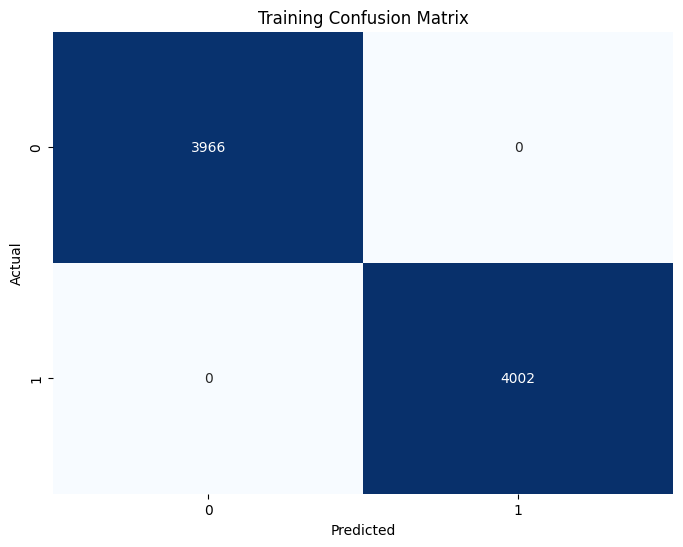

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[836  24]
 [ 24 824]]


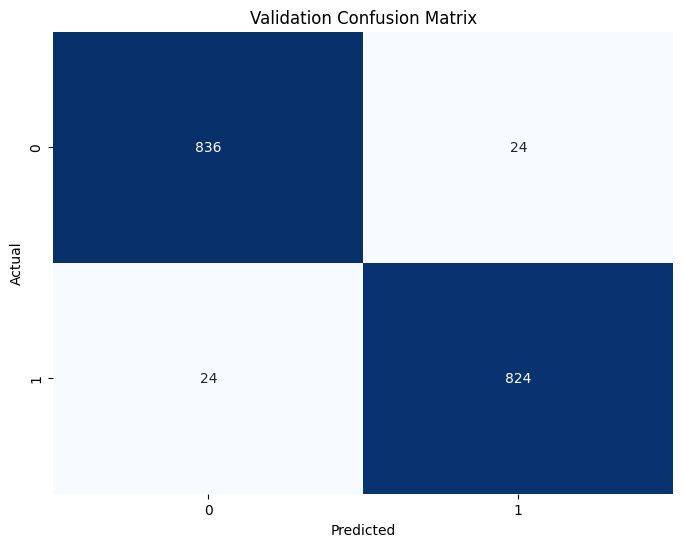

['XGB_without_missing.joblib']

In [ ]:
XGB_without_missing = xgb.XGBClassifier(random_state = 32, eval_metric='logloss', enable_categorical=True)
XGB_without_missing.fit(X_train,y_train)

# Training Score
XGB_without_missing_train_pred = XGB_without_missing.predict(X_train)

print("Classification Report:")
print(classification_report(y_train, XGB_without_missing_train_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_train, XGB_without_missing_train_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation Score
XGB_without_missing_val_pred = XGB_without_missing.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, XGB_without_missing_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_without_missing_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(XGB_without_missing, 'XGB_without_missing.joblib')


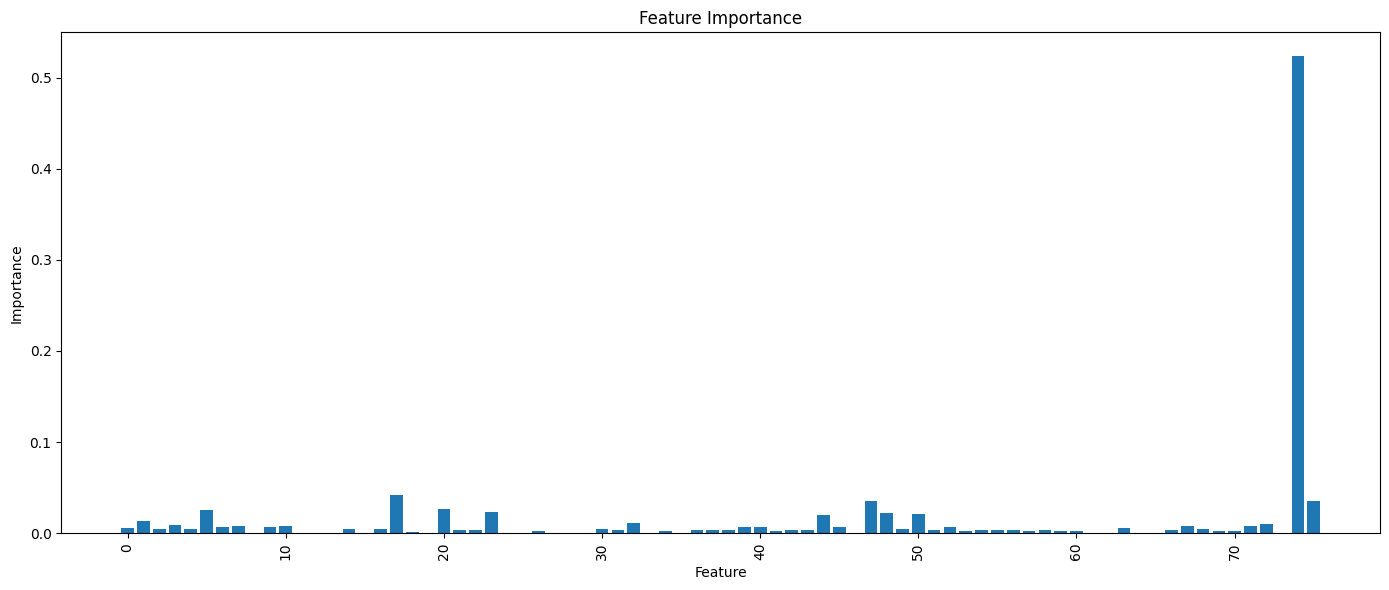

In [ ]:
# Plot feature importance scores for all features
feature_importances = XGB_without_missing.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Trained with high importance features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Valdiation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       860
           1       0.98      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Valdiation Confusion Matrix:
[[839  21]
 [ 24 824]]


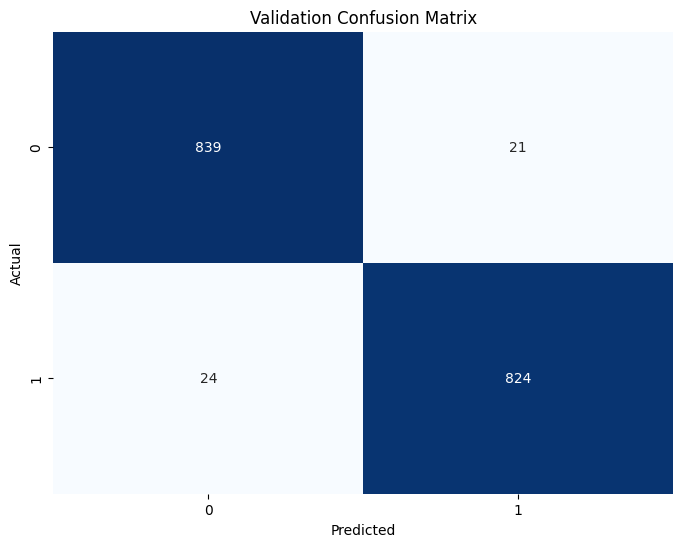

In [ ]:
# Feature Selection using SelectFromModel; > median feature importance scores are kept
selector = SelectFromModel(XGB_without_missing, threshold="median", prefit=True) # can add `max_features` to limit number of features
X_train_XGB_without_missing_fs = selector.transform(X_train)
X_val_XGB_without_missing_fs = selector.transform(X_val)
X_test_XGB_without_missing_fs = selector.transform(X_test)

# Retrain on Selected Features
XGB_without_missing_fs = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_without_missing_fs.fit(X_train_XGB_without_missing_fs, y_train)

# Training
XGB_without_missing_fs_train_pred = XGB_without_missing_fs.predict(X_train_XGB_without_missing_fs)
print("Training Classification Report:")
print(classification_report(y_train, XGB_without_missing_fs_train_pred))

# Valdiation
XGB_without_missing_fs_val_pred = XGB_without_missing_fs.predict(X_val_XGB_without_missing_fs)
print("Valdiation Classification Report:")
print(classification_report(y_val, XGB_without_missing_fs_val_pred))

print("Valdiation Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_without_missing_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
selected_features = X_train.columns[selector.get_support()]
selected_importances = XGB_without_missing.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm',
       'nb_and', 'nb_underscore', 'nb_percent', 'nb_slash', 'nb_semicolumn',
       'nb_space', 'nb_www', 'http_in_path', 'https_token',
       'ratio_digits_host', 'prefix_suffix', 'shortening_service',
       'char_repeat', 'shortest_words_raw', 'shortest_word_path',
       'longest_words_raw', 'phish_hints', 'domain_in_brand', 'brand_in_path',
       'suspecious_tld', 'statistical_report', 'nb_hyperlinks',
       'ratio_extHyperlinks', 'login_form', 'safe_anchor', 'empty_title',
       'domain_in_title', 'domain_with_copyright', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


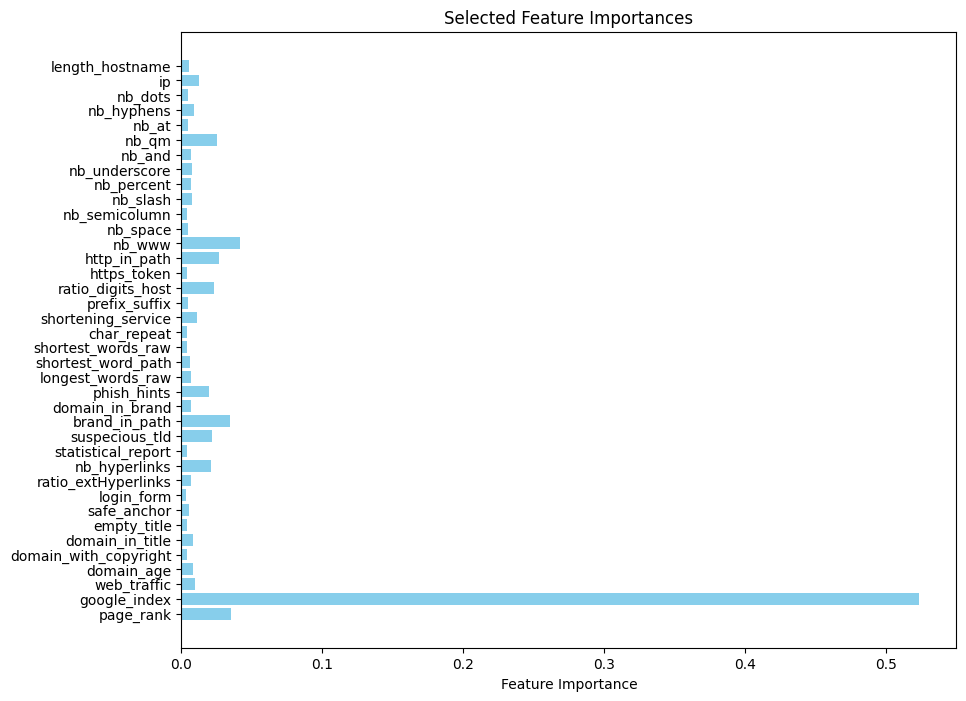

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### RFECV

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 fe

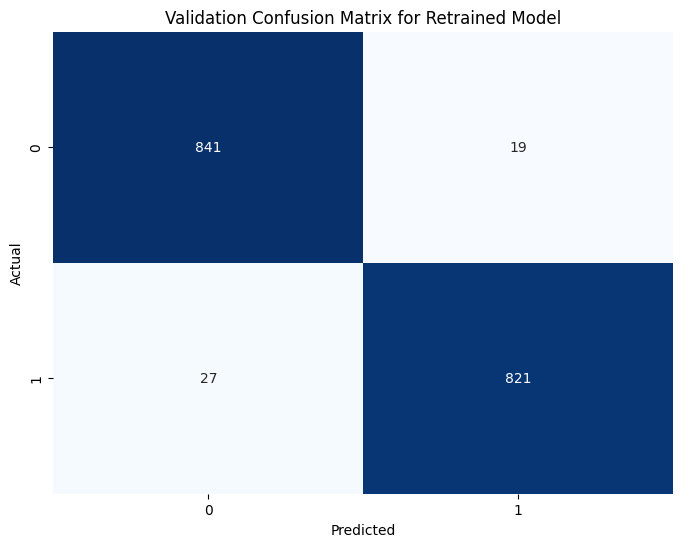

['XGB_without_missing_rfecv.joblib']

In [ ]:
# Perform RFECV for feature selection
rfecv = RFECV(estimator=XGB_without_missing, step=1, cv=5, scoring='f1', n_jobs=-1, verbose=2)
rfecv.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:")
print(selected_features)

# include only selected features
X_train_XGB_without_missing_rfecv = rfecv.transform(X_train)
X_val_XGB_without_missing_rfecv = rfecv.transform(X_val)

# Retrain the XGBoost model on selected features
XGB_without_missing_rfecv = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_without_missing_rfecv.fit(X_train_XGB_without_missing_rfecv, y_train)

# Validation
XGB_without_missing_rfecv_val_pred = XGB_without_missing_rfecv.predict(X_val_XGB_without_missing_rfecv)

print("Retrained Model Validation Classification Report:")
print(classification_report(y_val, XGB_without_missing_rfecv_val_pred))

print("Retrained Model Validation Confusion Matrix:")
cm_val_rfecv = confusion_matrix(y_val, XGB_without_missing_rfecv_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rfecv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Retrained Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the retrained model
joblib.dump(XGB_without_missing_rfecv, 'XGB_without_missing_rfecv.joblib')

## ANOVA

### Fitted model with ANOVA Selected Features

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix:
[[3966    0]
 [   0 4002]]


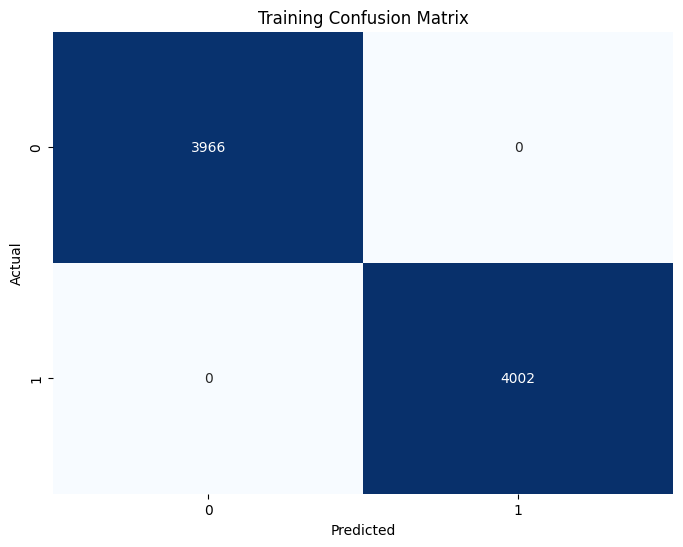

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[834  26]
 [ 25 823]]


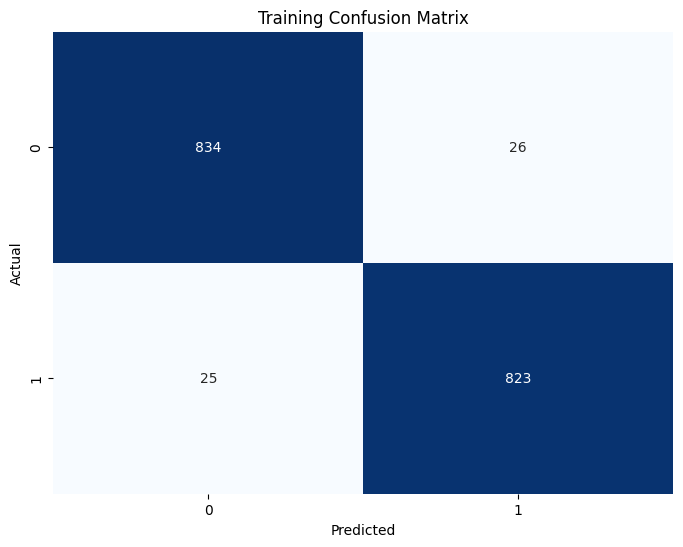

['XGB_anova.joblib']

In [ ]:
XGB_anova = xgb.XGBClassifier(random_state = 32, eval_metric='logloss', enable_categorical=True)
XGB_anova.fit(X_train_anova,y_train)

XGB_anova_train_pred = XGB_anova.predict(X_train_anova)

print("Classification Report:")
print(classification_report(y_train, XGB_anova_train_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_train, XGB_anova_train_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation Score
XGB_anova_val_pred = XGB_anova.predict(X_val_anova)


print("Classification Report:")
print(classification_report(y_val, XGB_anova_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_anova_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# save model
joblib.dump(XGB_anova, 'XGB_anova.joblib')


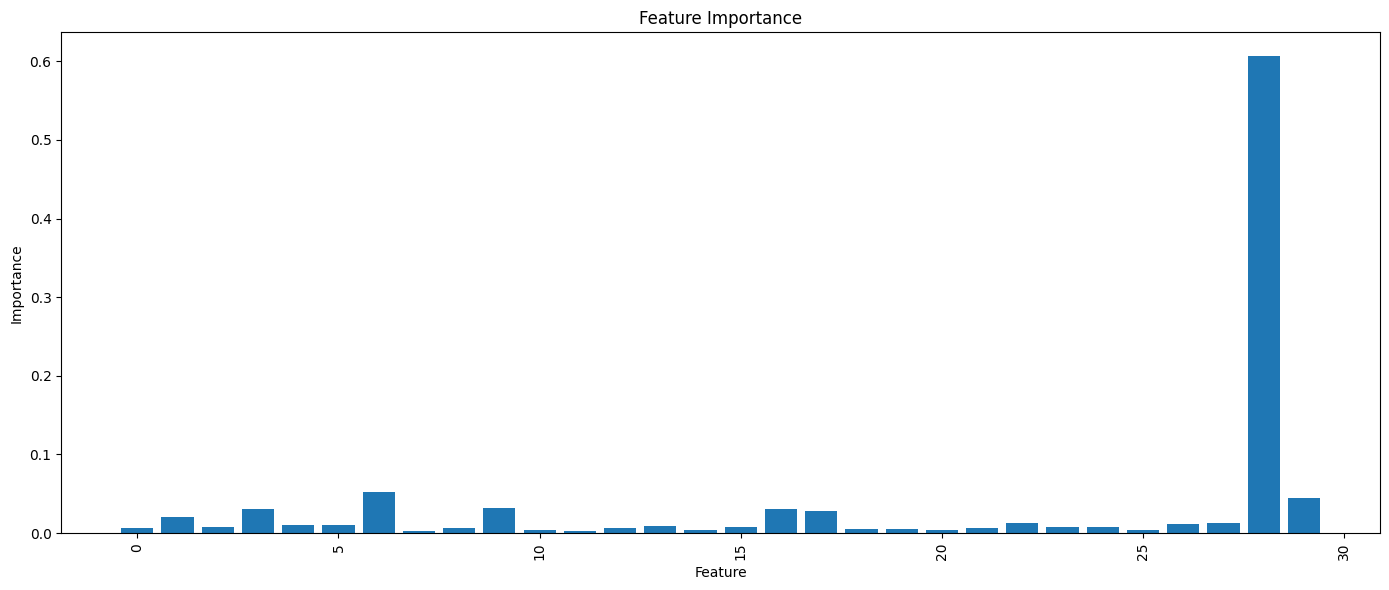

In [ ]:
# Plot feature importance scores for all features
feature_importances = XGB_anova.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


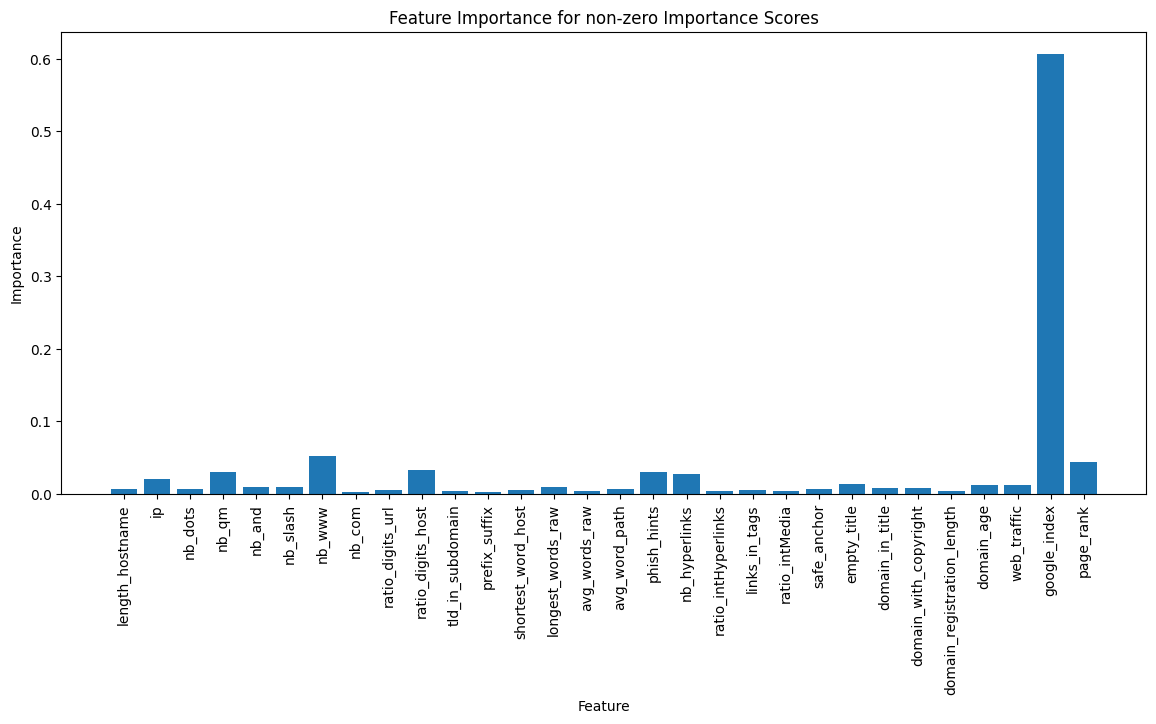

In [ ]:
# removed the features that have a feature score of 0
non_zero_feature_importances = [importance for importance in feature_importances if importance > 0]

non_zero_feature_indices = [index for index, importance in enumerate(feature_importances) if importance > 0]

non_zero_feature_names = [X_train_anova.columns[index] for index in non_zero_feature_indices]

plt.figure(figsize=(14, 6))
plt.bar(range(len(non_zero_feature_importances)), non_zero_feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for non-zero Importance Scores')
plt.xticks(range(len(non_zero_feature_importances)), non_zero_feature_names, rotation=90)

plt.show()


## With Embeddings

### Fitted Model with all features

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix (Training):
[[3966    0]
 [   0 4002]]


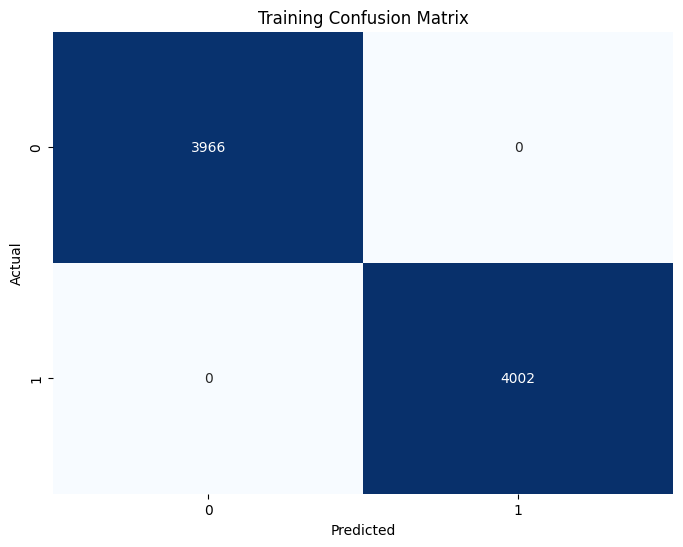

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix (Validation):
[[838  22]
 [ 29 819]]


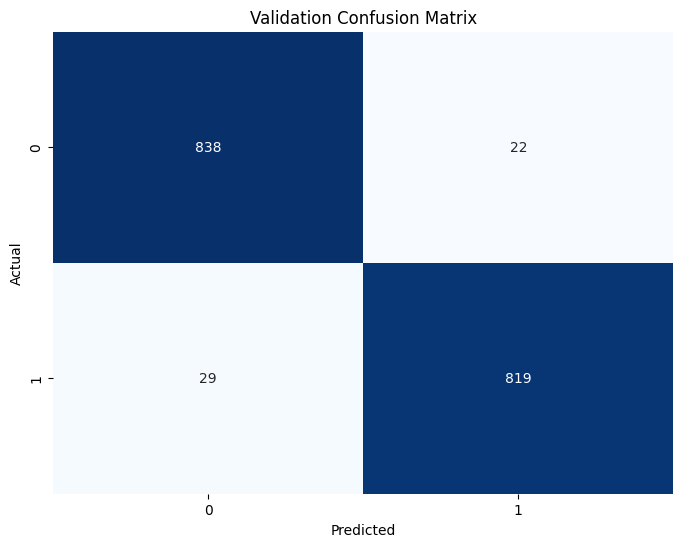

['XGB_emb.joblib']

In [ ]:
XGB_emb = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_emb.fit(X_train_emb, y_train)

XGB_emb_train_pred = XGB_emb.predict(X_train_emb)

print("Classification Report (Training):")
print(classification_report(y_train, XGB_emb_train_pred))

print("Confusion Matrix (Training):")
cm_train = confusion_matrix(y_train, XGB_emb_train_pred)
print(cm_train)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation Score
XGB_emb_val_pred = XGB_emb.predict(X_val_emb)

print("Classification Report (Validation):")
print(classification_report(y_val, XGB_emb_val_pred))

print("Confusion Matrix (Validation):")
cm_val = confusion_matrix(y_val, XGB_emb_val_pred)
print(cm_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_emb, 'XGB_emb.joblib')

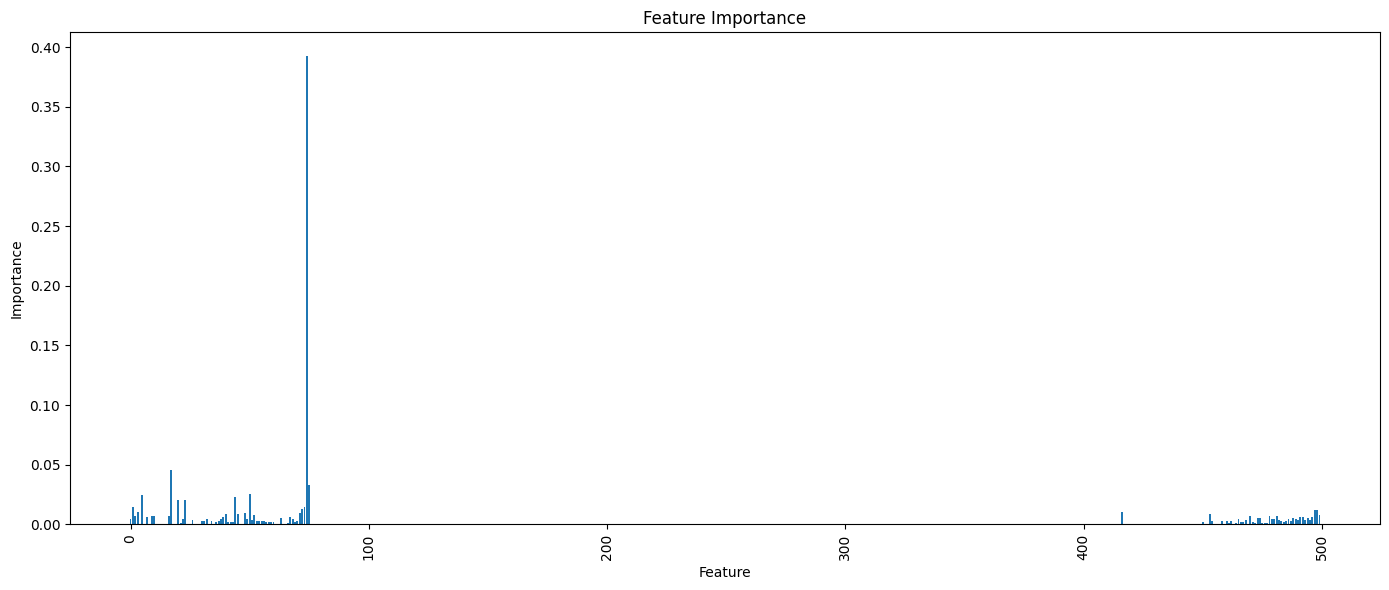

In [ ]:
# Plot feature importance scores for all features

feature_importances = XGB_emb.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Trained with high importance features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Validation Confusion Matrix:
[[838  22]
 [ 29 819]]


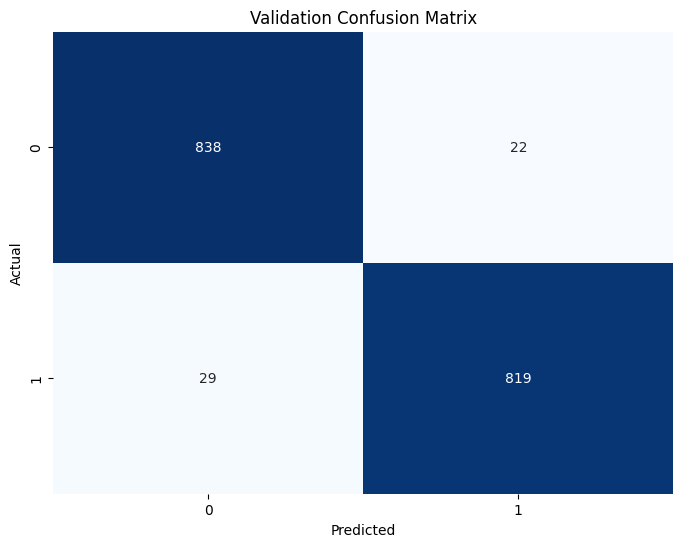

['XGB_emb_fs.joblib']

In [ ]:
selector = SelectFromModel(XGB_emb, threshold="median", prefit=True)  # Adjust threshold or add max_features if needed

X_train_XGB_emb_fs = selector.transform(X_train_emb)
X_val_XGB_emb_fs = selector.transform(X_val_emb)
X_test_XGB_emb_fs = selector.transform(X_test_emb)

# Retrain on Selected Features
XGB_emb_fs = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_emb_fs.fit(X_train_XGB_emb_fs, y_train)

# Training
XGB_emb_fs_train_pred = XGB_emb_fs.predict(X_train_XGB_emb_fs)
print("Training Classification Report:")
print(classification_report(y_train, XGB_emb_fs_train_pred))

# Validation
XGB_emb_fs_val_pred = XGB_emb_fs.predict(X_val_XGB_emb_fs)
print("Validation Classification Report:")
print(classification_report(y_val, XGB_emb_fs_val_pred))


print("Validation Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_emb_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save the model
joblib.dump(XGB_emb_fs, 'XGB_emb_fs.joblib')

In [ ]:
selected_features = X_train_emb.columns[selector.get_support()]
selected_importances = XGB_emb.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm',
       'nb_and', 'nb_underscore', 'nb_tilde', 'nb_percent',
       ...
       '414', '415', '416', '417', '418', '419', '420', '421', '422', '423'],
      dtype='object', length=500)
Number of Features Selected: 500


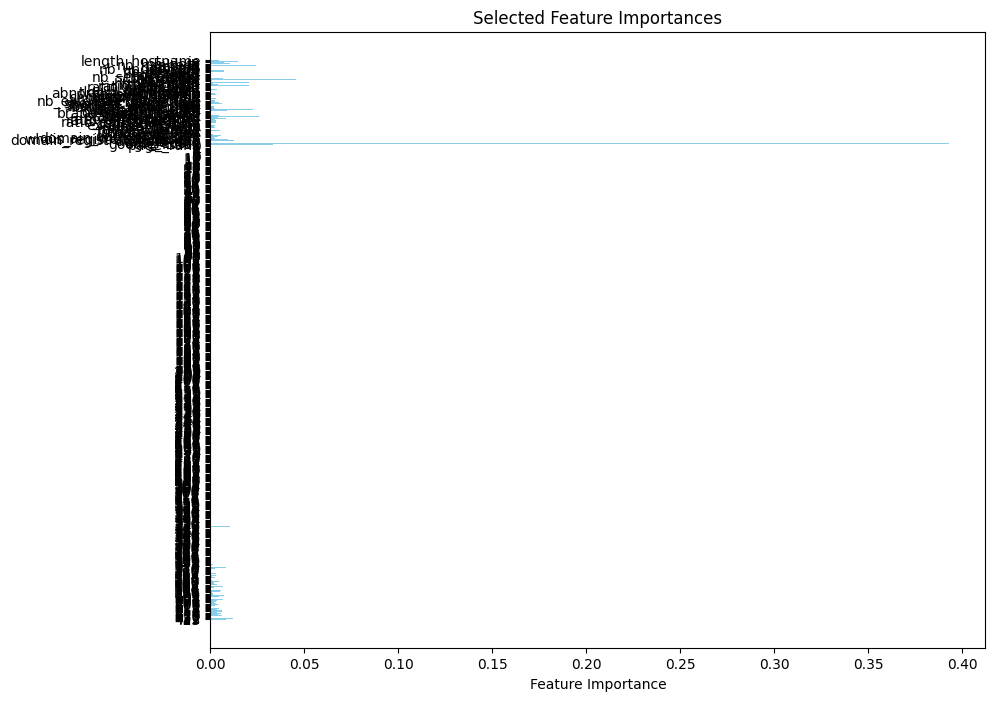

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### RFECV

Fitting estimator with 500 features.
Fitting estimator with 499 features.
Fitting estimator with 498 features.
Fitting estimator with 497 features.
Fitting estimator with 496 features.
Fitting estimator with 495 features.
Fitting estimator with 494 features.
Fitting estimator with 493 features.
Fitting estimator with 492 features.
Fitting estimator with 491 features.
Fitting estimator with 490 features.
Fitting estimator with 489 features.
Fitting estimator with 488 features.
Fitting estimator with 487 features.
Fitting estimator with 486 features.
Fitting estimator with 485 features.
Fitting estimator with 484 features.
Fitting estimator with 483 features.
Fitting estimator with 482 features.
Fitting estimator with 481 features.
Fitting estimator with 480 features.
Fitting estimator with 479 features.
Fitting estimator with 478 features.
Fitting estimator with 477 features.
Fitting estimator with 476 features.
Fitting estimator with 475 features.
Fitting estimator with 474 features.
F

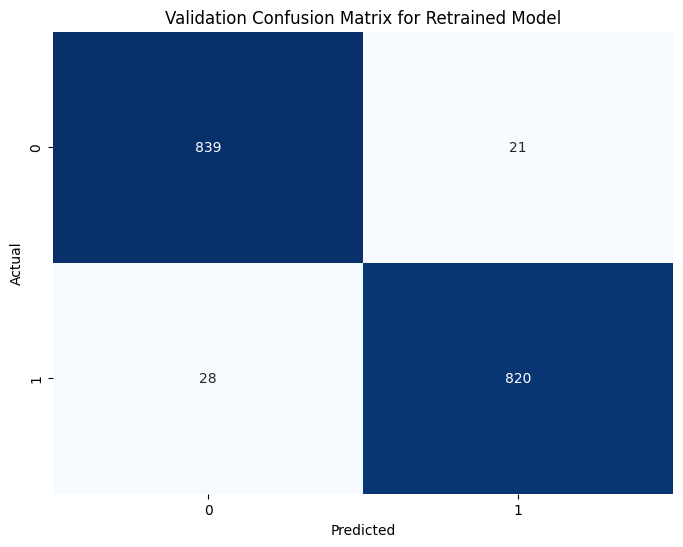

['XGB_emb_rfecv.joblib']

In [ ]:
rfecv = RFECV(estimator=XGB_emb, step=1, cv=5, scoring='f1', n_jobs=-1, verbose=2)
rfecv.fit(X_train_emb, y_train)

# selected features
selected_features = X_train_emb.columns[rfecv.support_]  # Assuming X_train_emb is a DataFrame
print("Selected Features:")
print(selected_features)

# include only selected features
X_train_XGB_emb_rfecv = rfecv.transform(X_train_emb)
X_val_XGB_emb_rfecv = rfecv.transform(X_val_emb)

# Retrain on selected features
XGB_emb_rfecv = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_emb_rfecv.fit(X_train_XGB_emb_rfecv, y_train)

# Validation
XGB_emb_rfecv_val_pred = XGB_emb_rfecv.predict(X_val_XGB_emb_rfecv)

print("Retrained Model Validation Classification Report:")
print(classification_report(y_val, XGB_emb_rfecv_val_pred))

print("Retrained Model Validation Confusion Matrix:")
cm_val_rfecv = confusion_matrix(y_val, XGB_emb_rfecv_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rfecv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Retrained Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the retrained model
joblib.dump(XGB_emb_rfecv, 'XGB_emb_rfecv.joblib')

## With Encodings

In [ ]:
# for encodings, since already feature selected from vae, will not feature select again via feature importance scores
# 1) trained on dataset, 2) tuned

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix (Training):


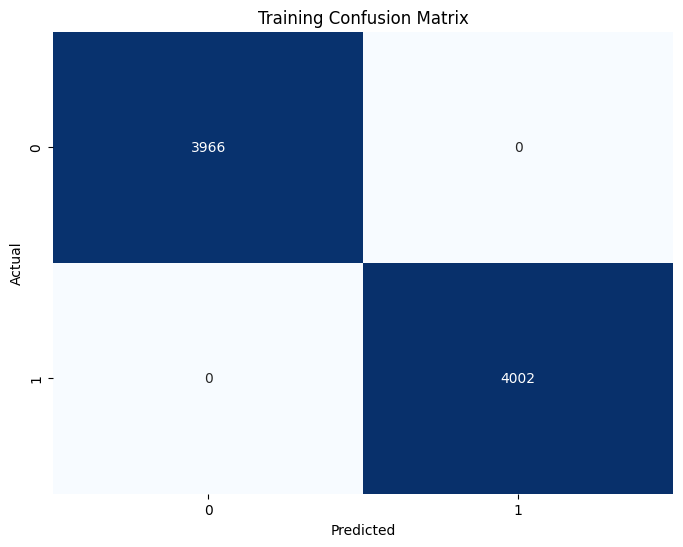

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       860
           1       0.94      0.93      0.93       848

    accuracy                           0.93      1708
   macro avg       0.93      0.93      0.93      1708
weighted avg       0.93      0.93      0.93      1708

Confusion Matrix (Validation):


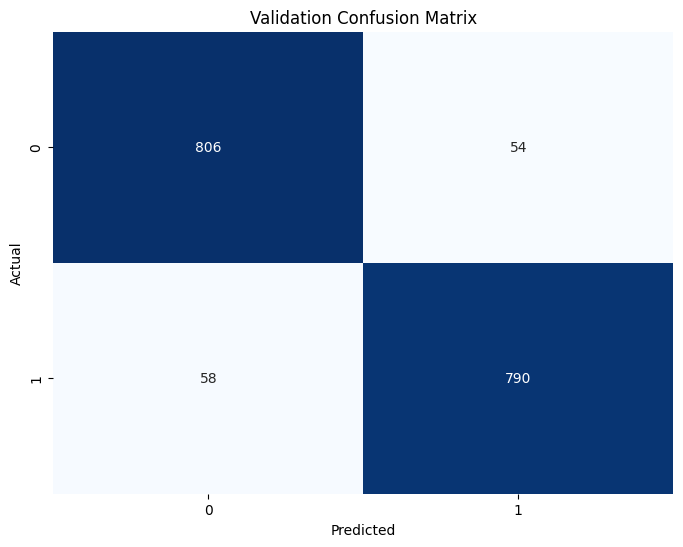

['XGB_encoded.joblib']

In [ ]:
# Using encoded training set
XGB_encoded = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_encoded.fit(X_train_encoded, y_train)

# Training
XGB_encoded_train_pred = XGB_encoded.predict(X_train_encoded)

print("Classification Report (Training):")
print(classification_report(y_train, XGB_encoded_train_pred))

print("Confusion Matrix (Training):")
cm_train = confusion_matrix(y_train, XGB_encoded_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation
XGB_encoded_val_pred = XGB_encoded.predict(X_val_encoded)

print("Classification Report (Validation):")
print(classification_report(y_val, XGB_encoded_val_pred))

print("Confusion Matrix (Validation):")
cm_val = confusion_matrix(y_val, XGB_encoded_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_encoded, 'XGB_encoded.joblib')


## With Embeddings + Encoding

In [ ]:
# for encodings, since already feature selected from vae, will not feature select again via feature importance scores
# 1) trained on dataset, 2) tuned

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix (Training):


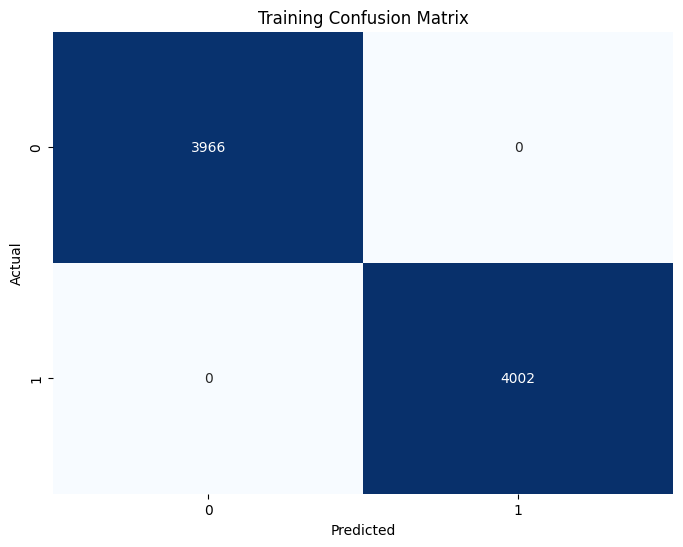

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       860
           1       0.95      0.92      0.93       848

    accuracy                           0.93      1708
   macro avg       0.93      0.93      0.93      1708
weighted avg       0.93      0.93      0.93      1708

Confusion Matrix (Validation):


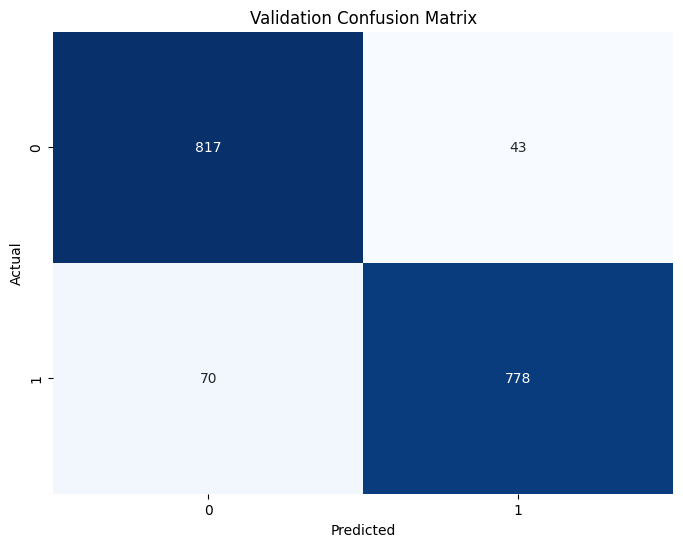

['XGB_emb_encoded.joblib']

In [ ]:
# Using embedded encoded training set
XGB_emb_encoded = xgb.XGBClassifier(random_state=32, eval_metric='logloss', enable_categorical=True)
XGB_emb_encoded.fit(X_train_emb_encoded, y_train)

# Training Score
XGB_emb_encoded_train_pred = XGB_emb_encoded.predict(X_train_emb_encoded)

print("Classification Report (Training):")
print(classification_report(y_train, XGB_emb_encoded_train_pred))

print("Confusion Matrix (Training):")
cm_emb_train = confusion_matrix(y_train, XGB_emb_encoded_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation
XGB_emb_encoded_val_pred = XGB_emb_encoded.predict(X_val_emb_encoded)

print("Classification Report (Validation):")
print(classification_report(y_val, XGB_emb_encoded_val_pred))

print("Confusion Matrix (Validation):")
cm_emb_val = confusion_matrix(y_val, XGB_emb_encoded_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_emb_encoded, 'XGB_emb_encoded.joblib')


# LightGBM
Learns node-wise
Fast, but may be prone to overfitting

Histogram-based
Groups feature values into bins
Reduces computational cost


## All features (without_missing)

### Fitted Model with all features

[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4370
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix:
[[3961    5]
 [  12 3990]]
Classification Report:
              precision    re

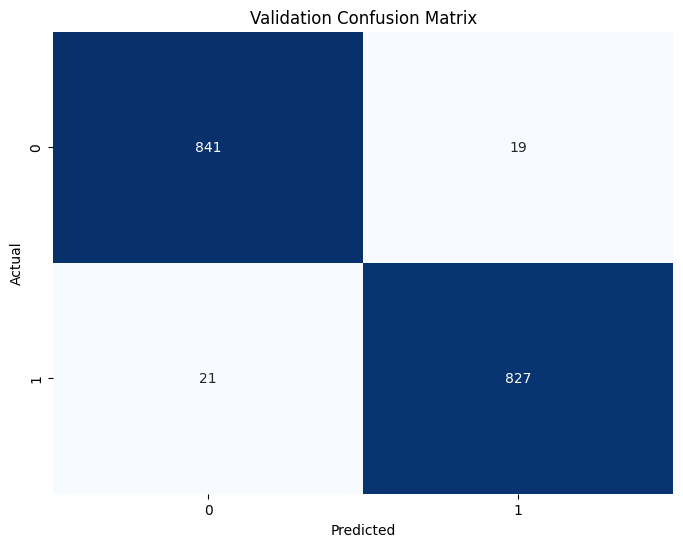

['LGB_without_missing.joblib']

In [ ]:

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}
train_data = lgb.Dataset(X_train, label=y_train)

LGB_without_missing = lgb.LGBMClassifier(params, train_set = train_data)
LGB_without_missing.__init__(boosting_type='gbdt')
LGB_without_missing.fit(X_train, y_train)

# Training Score
LGB_without_missing_train_pred = LGB_without_missing.predict(X_train)
print("Classification Report:")
print(classification_report(y_train, LGB_without_missing_train_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_train, LGB_without_missing_train_pred)
print(cm)

# Validation Score
LGB_without_missing_val_pred = LGB_without_missing.predict(X_val)


print("Classification Report:")
print(classification_report(y_val, LGB_without_missing_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_without_missing_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(LGB_without_missing, 'LGB_without_missing.joblib')


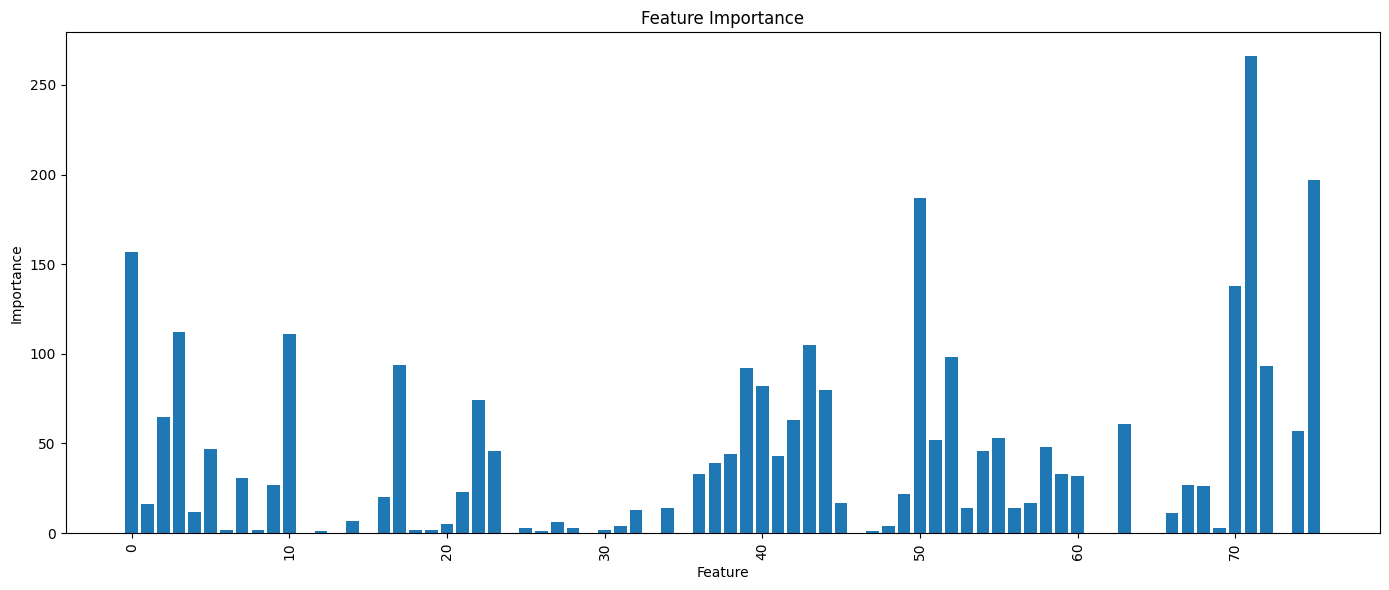

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_without_missing.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Trained with high importance features

In [ ]:
# Feature Selection with SelectFromModel
selector = SelectFromModel(LGB_without_missing, threshold="median", prefit=True) # can add `max_features` to limit number of features
X_train_LGB_without_missing_fs = selector.transform(X_train)
X_val_LGB_without_missing_fs = selector.transform(X_val)
X_test_LGB_without_missing_fs = selector.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4250
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix:
[[3961    5]
 [  10 3992]]
Classification Report:
              precision    re

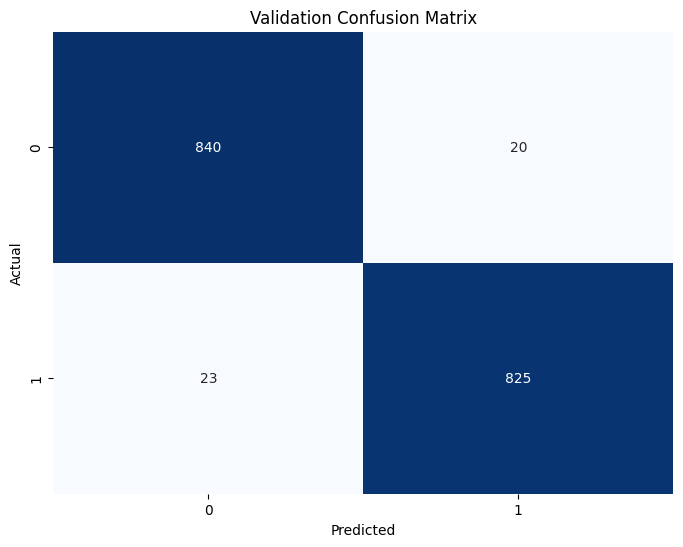

['LGB_without_missing_fs.joblib']

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}
train_data = lgb.Dataset(X_train_LGB_without_missing_fs, label=y_train)

LGB_without_missing_fs = lgb.LGBMClassifier(params, train_set = train_data) #include early stopping when we tune
LGB_without_missing_fs.__init__(boosting_type='gbdt')
LGB_without_missing_fs.fit(X_train_LGB_without_missing_fs, y_train)

# Training Score
LGB_without_missing_fs_train_pred = LGB_without_missing_fs.predict(X_train_LGB_without_missing_fs)
print("Classification Report:")
print(classification_report(y_train, LGB_without_missing_fs_train_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_train, LGB_without_missing_fs_train_pred)
print(cm)

# Validation
LGB_without_missing_fs_val_pred = LGB_without_missing_fs.predict(X_val_LGB_without_missing_fs)


print("Classification Report:")
print(classification_report(y_val, LGB_without_missing_fs_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_without_missing_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(LGB_without_missing_fs, 'LGB_without_missing_fs.joblib')


In [ ]:
selected_features = X_train.columns[selector.get_support()]
selected_importances = LGB_without_missing.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_underscore',
       'nb_percent', 'nb_slash', 'nb_space', 'nb_www', 'https_token',
       'ratio_digits_url', 'ratio_digits_host', 'char_repeat',
       'shortest_words_raw', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_host', 'avg_words_raw',
       'avg_word_path', 'phish_hints', 'statistical_report', 'nb_hyperlinks',
       'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


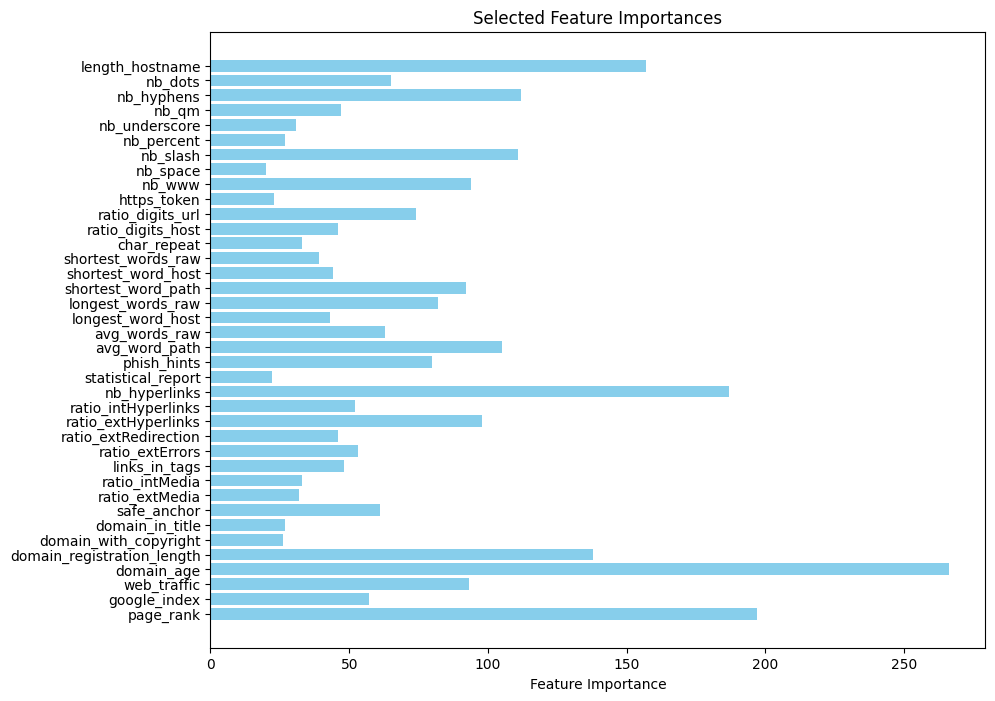

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### RFECV

Fitting estimator with 76 features.
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4370
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Fitting estimator with 75 features.
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4368
[LightGBM] [Info] Number of data points in the

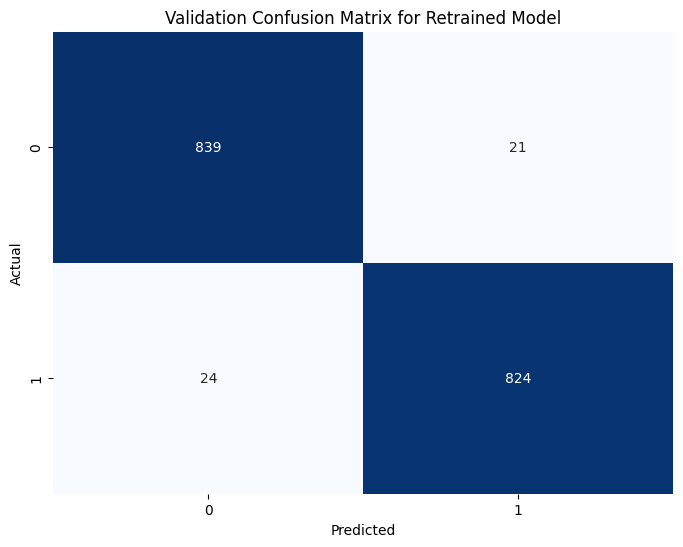

['LGB_without_missing_rfecv.joblib']

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}

rfecv = RFECV(estimator=lgb.LGBMClassifier(), step=1, cv=5, scoring='f1', n_jobs=-1, verbose=2)
rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
print("Selected Features:")
print(selected_features)

# include only selected features
X_train_LGB_without_missing_rfecv = rfecv.transform(X_train)
X_val_LGB_without_missing_rfecv = rfecv.transform(X_val)

LGB_without_missing_rfecv = lgb.LGBMClassifier(**params)
LGB_without_missing_rfecv.fit(X_train_LGB_without_missing_rfecv, y_train)

# Validation
LGB_without_missing_rfecv_val_pred = LGB_without_missing_rfecv.predict(X_val_LGB_without_missing_rfecv)

print("Retrained Model Validation Classification Report:")
print(classification_report(y_val, LGB_without_missing_rfecv_val_pred))

print("Retrained Model Validation Confusion Matrix:")
cm_val_rfecv = confusion_matrix(y_val, LGB_without_missing_rfecv_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rfecv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Retrained Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the retrained model
joblib.dump(LGB_without_missing_rfecv, 'LGB_without_missing_rfecv.joblib')

## ANOVA

### Fitted model with ANOVA Selected Features

[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Confusion Matrix:
[[3956   10]
 [  18 3984]]
Classification Report:
              precision    re

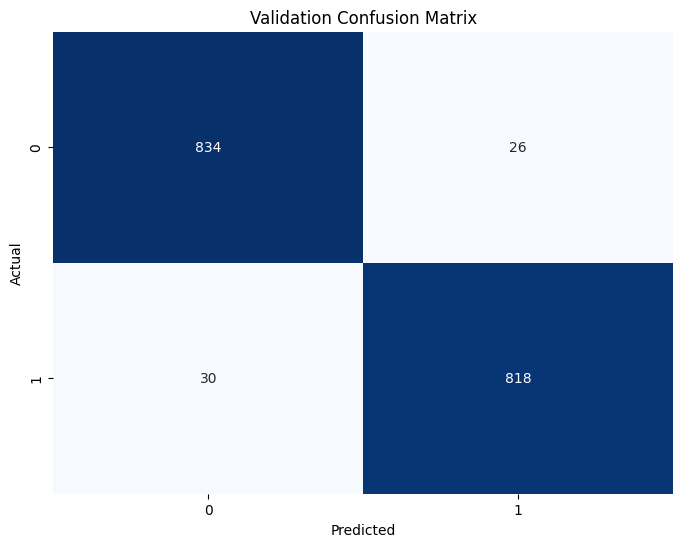

['LGB_anova.joblib']

In [ ]:

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}
train_data = lgb.Dataset(X_train_anova, label=y_train)

LGB_anova = lgb.LGBMClassifier(params, train_set = train_data) #include early stopping when we tune
LGB_anova.__init__(boosting_type='gbdt')
LGB_anova.fit(X_train_anova, y_train)

# Training
LGB_anova_train_pred = LGB_anova.predict(X_train_anova)

print("Classification Report:")
print(classification_report(y_train, LGB_anova_train_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_train, LGB_anova_train_pred)
print(cm)

# Validation
LGB_anova_val_pred = LGB_anova.predict(X_val_anova)

print("Classification Report:")
print(classification_report(y_val, LGB_anova_val_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_anova_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# save model
joblib.dump(LGB_anova, 'LGB_anova.joblib')


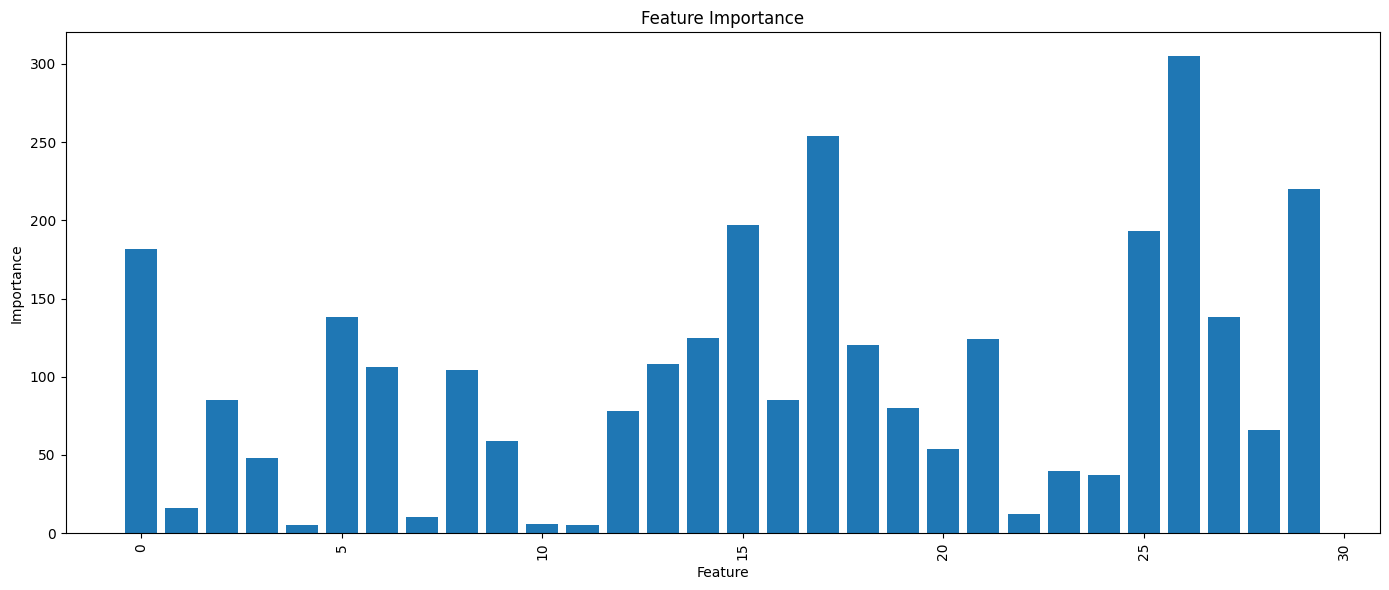

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_anova.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## With Embeddings

### Fitted Model with all features

[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21094
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Training Confusion Matrix:
[[3966    0]
 [   2 4000]]
Validation Classification Report

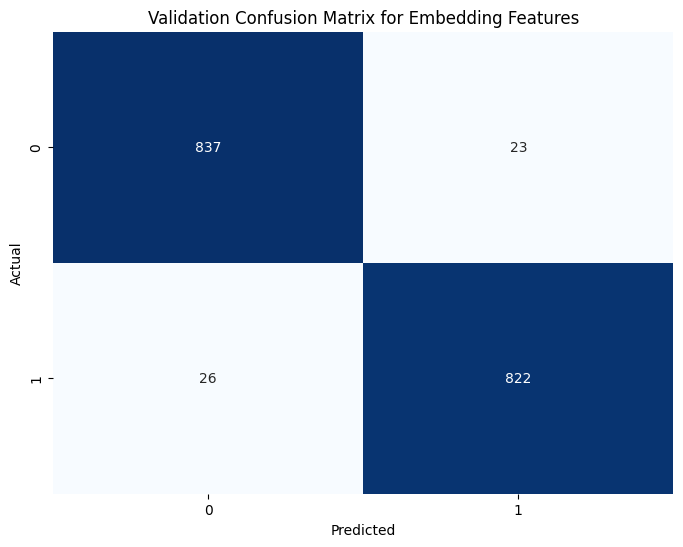

['LGB_emb.joblib']

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 32
}

LGB_emb = lgb.LGBMClassifier(**params)
LGB_emb.fit(X_train_emb, y_train)

# Training
LGB_emb_train_pred = LGB_emb.predict(X_train_emb)
print("Training Classification Report:")
print(classification_report(y_train, LGB_emb_train_pred))
print("Training Confusion Matrix:")
cm_train = confusion_matrix(y_train, LGB_emb_train_pred)
print(cm_train)

# Validation
LGB_emb_val_pred = LGB_emb.predict(X_val_emb)
print("Validation Classification Report:")
print(classification_report(y_val, LGB_emb_val_pred))

print("Validation Confusion Matrix:")
cm_val = confusion_matrix(y_val, LGB_emb_val_pred)
print(cm_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Embedding Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model
joblib.dump(LGB_emb, 'LGB_emb.joblib')

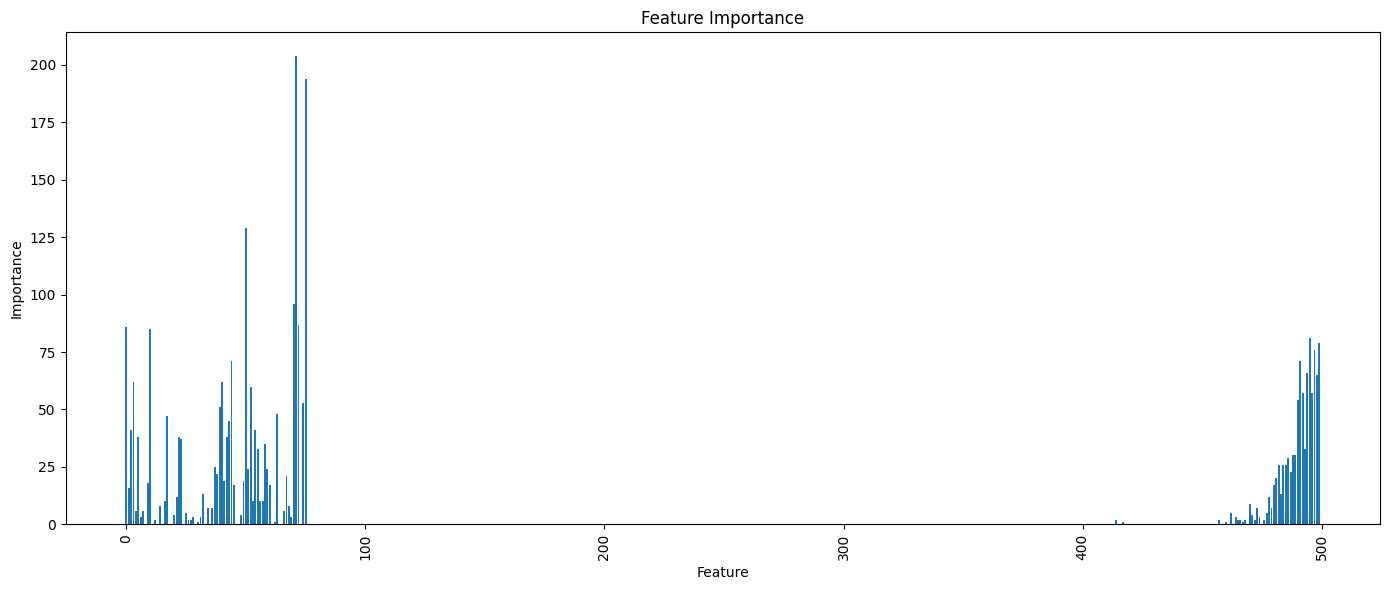

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_emb.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Trained with high importance features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21094
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3966
           1       1.00      1.00      1.00      4002

    accuracy                           1.00      7968
   macro avg       1.00      1.00      1.00      7968
weighted avg       1.00      1.00      1.00      7968

Training Confusion Matrix:
[[3966    0]
 [   2 4000]]
Validation Classification Report

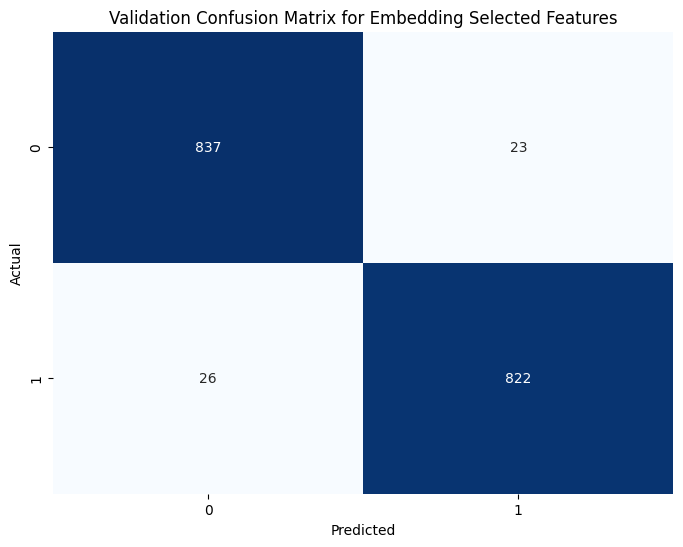

['LGB_emb_fs.joblib']

In [ ]:
# Feature Selection with SelectFromModel for Embedding Features
selector = SelectFromModel(LGB_emb, threshold="median", prefit=True)  # Adjust threshold or add `max_features` if needed
X_train_LGB_emb_fs = selector.transform(X_train_emb)
X_val_LGB_emb_fs = selector.transform(X_val_emb)
X_test_LGB_emb_fs = selector.transform(X_test_emb)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 32
}

LGB_emb_fs = lgb.LGBMClassifier(**params)
LGB_emb_fs.fit(X_train_LGB_emb_fs, y_train)

# Training
LGB_emb_fs_train_pred = LGB_emb_fs.predict(X_train_LGB_emb_fs)
print("Training Classification Report:")
print(classification_report(y_train, LGB_emb_fs_train_pred))
print("Training Confusion Matrix:")
cm_train = confusion_matrix(y_train, LGB_emb_fs_train_pred)
print(cm_train)

# Validation
LGB_emb_fs_val_pred = LGB_emb_fs.predict(X_val_LGB_emb_fs)
print("Validation Classification Report:")
print(classification_report(y_val, LGB_emb_fs_val_pred))
print("Validation Confusion Matrix:")
cm_val = confusion_matrix(y_val, LGB_emb_fs_val_pred)
print(cm_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Embedding Selected Features")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model
joblib.dump(LGB_emb_fs, 'LGB_emb_fs.joblib')


In [ ]:
selected_features = X_train_emb.columns[selector.get_support()]
selected_importances = LGB_emb.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm',
       'nb_and', 'nb_underscore', 'nb_tilde', 'nb_percent',
       ...
       '414', '415', '416', '417', '418', '419', '420', '421', '422', '423'],
      dtype='object', length=500)
Number of Features Selected: 500


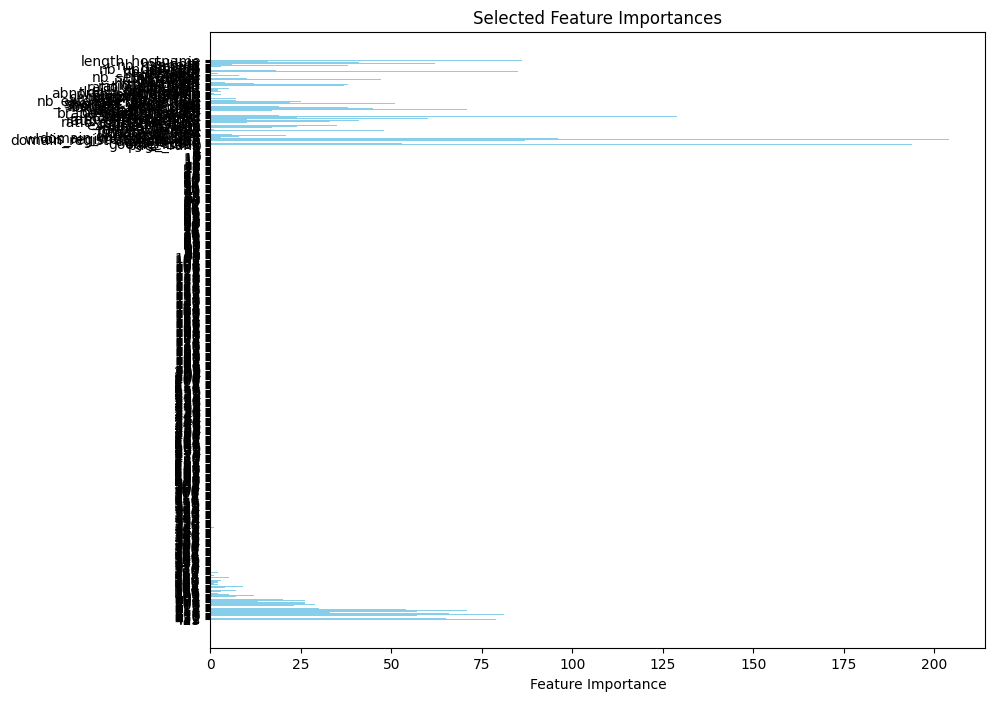

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### RFECV

Fitting estimator with 500 features.
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21094
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 221
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Fitting estimator with 499 features.
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21094
[LightGBM] [Info] Number of data points i

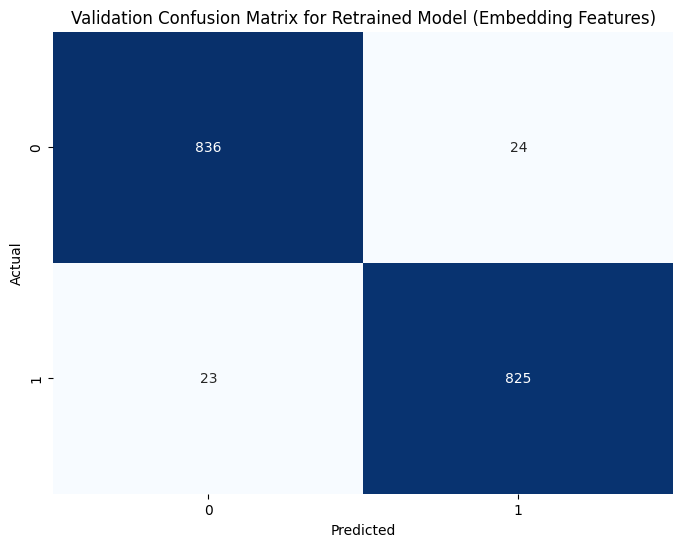

['LGB_emb_rfecv.joblib']

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}

rfecv_emb = RFECV(estimator=lgb.LGBMClassifier(), step=1, cv=5, scoring='f1', n_jobs=-1, verbose=2)
rfecv_emb.fit(X_train_emb, y_train)

selected_features_emb = X_train_emb.columns[rfecv_emb.support_]
print("Selected Features for Embedding Model:")
print(selected_features_emb)

X_train_LGB_emb_rfecv = rfecv_emb.transform(X_train_emb)
X_val_LGB_emb_rfecv = rfecv_emb.transform(X_val_emb)

LGB_emb_rfecv = lgb.LGBMClassifier(**params)
LGB_emb_rfecv.fit(X_train_LGB_emb_rfecv, y_train)

# Validation
LGB_emb_rfecv_val_pred = LGB_emb_rfecv.predict(X_val_LGB_emb_rfecv)

print("Retrained Model Validation Classification Report (Embedding Features):")
print(classification_report(y_val, LGB_emb_rfecv_val_pred))
print("Retrained Model Validation Confusion Matrix (Embedding Features):")
cm_val_rfecv_emb = confusion_matrix(y_val, LGB_emb_rfecv_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rfecv_emb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for Retrained Model (Embedding Features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the retrained model
joblib.dump(LGB_emb_rfecv, 'LGB_emb_rfecv.joblib')

## With Encodings

[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report (Training - Regular Encoded):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3966
           1       0.99      0.99      0.99      4002

    accuracy                           0.99      7968
   macro avg       0.99      0.99      0.99      7968
weighted avg       0.99      0.99      0.99      7968

Confusion Matrix (Training - Regular Encoded):


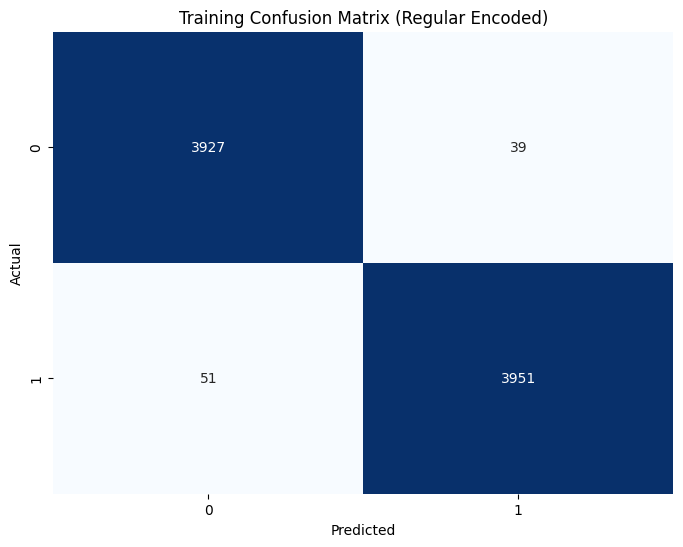

Classification Report (Validation - Regular Encoded):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       860
           1       0.94      0.93      0.94       848

    accuracy                           0.94      1708
   macro avg       0.94      0.94      0.94      1708
weighted avg       0.94      0.94      0.94      1708

Confusion Matrix (Validation - Regular Encoded):


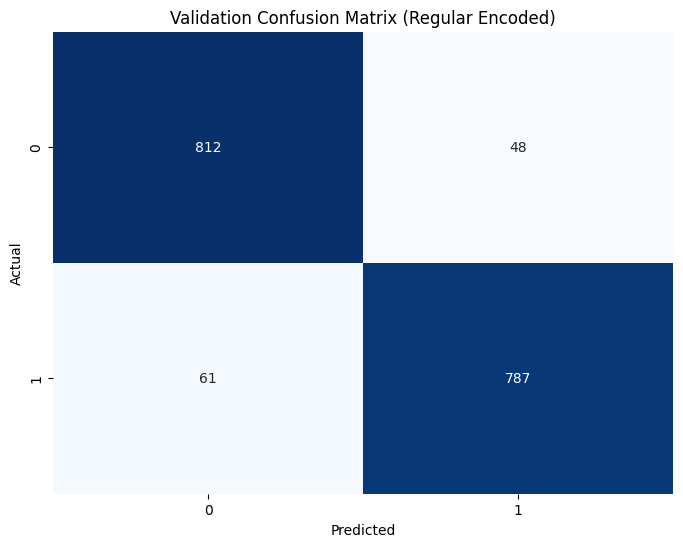

['LGB_encoded.joblib']

In [ ]:

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}

train_data_encoded = lgb.Dataset(X_train_encoded, label=y_train)

LGB_encoded = lgb.LGBMClassifier(**params)
LGB_encoded.fit(X_train_encoded, y_train)

# Training Score
LGB_encoded_train_pred = LGB_encoded.predict(X_train_encoded)

print("Classification Report (Training - Regular Encoded):")
print(classification_report(y_train, LGB_encoded_train_pred))

print("Confusion Matrix (Training - Regular Encoded):")
cm_encoded_train = confusion_matrix(y_train, LGB_encoded_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_encoded_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix (Regular Encoded)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation
LGB_encoded_val_pred = LGB_encoded.predict(X_val_encoded)

print("Classification Report (Validation - Regular Encoded):")
print(classification_report(y_val, LGB_encoded_val_pred))
print("Confusion Matrix (Validation - Regular Encoded):")
cm_encoded_val = confusion_matrix(y_val, LGB_encoded_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_encoded_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Regular Encoded)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_encoded, 'LGB_encoded.joblib')


## With Embeddings + Encoding

[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report (Training - Embedded Encoded):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3966
           1       0.99      0.99      0.99      4002

    accuracy                           0.99      7968
   macro avg       0.99      0.99      0.99      7968
weighted avg       0.99      0.99      0.99      7968

Confusion Matrix (Training - Embedded Encoded):


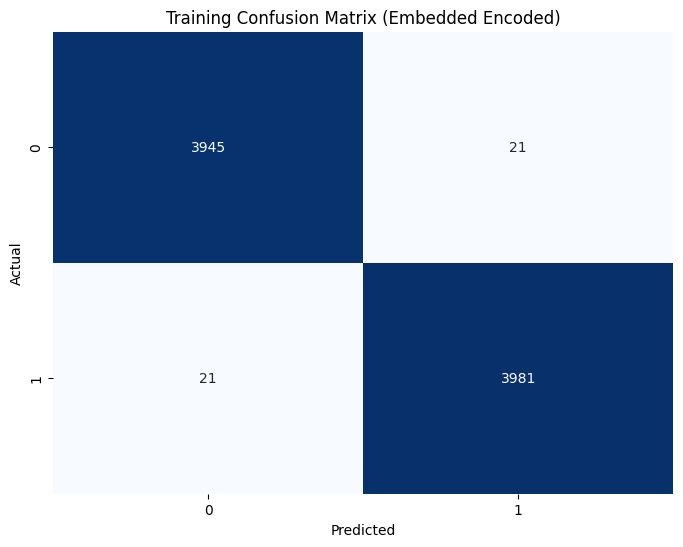

Classification Report (Validation - Embedded Encoded):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       860
           1       0.94      0.92      0.93       848

    accuracy                           0.93      1708
   macro avg       0.93      0.93      0.93      1708
weighted avg       0.93      0.93      0.93      1708

Confusion Matrix (Validation - Embedded Encoded):


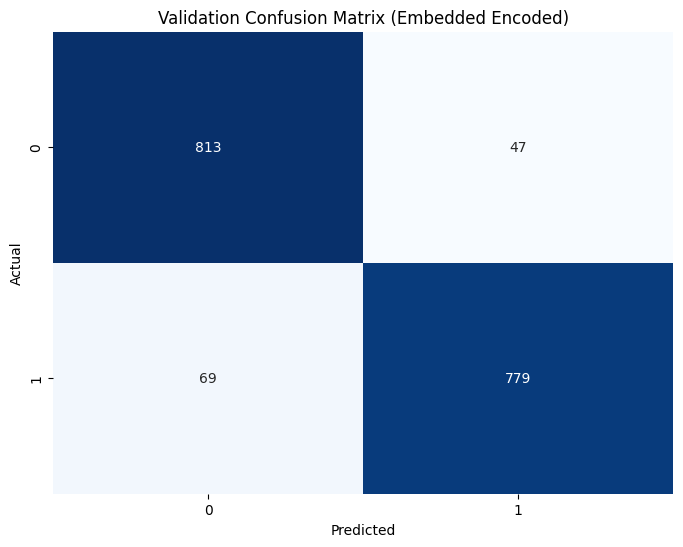

['LGB_emb_encoded.joblib']

In [ ]:

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'random_state': 32,
}

train_data_emb = lgb.Dataset(X_train_emb_encoded, label=y_train)
LGB_emb_encoded = lgb.LGBMClassifier(**params)
LGB_emb_encoded.fit(X_train_emb_encoded, y_train)

# Training
LGB_emb_encoded_train_pred = LGB_emb_encoded.predict(X_train_emb_encoded)

print("Classification Report (Training - Embedded Encoded):")
print(classification_report(y_train, LGB_emb_encoded_train_pred))

print("Confusion Matrix (Training - Embedded Encoded):")
cm_emb_train = confusion_matrix(y_train, LGB_emb_encoded_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Training Confusion Matrix (Embedded Encoded)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Validation
LGB_emb_encoded_val_pred = LGB_emb_encoded.predict(X_val_emb_encoded)

print("Classification Report (Validation - Embedded Encoded):")
print(classification_report(y_val, LGB_emb_encoded_val_pred))

print("Confusion Matrix (Validation - Embedded Encoded):")
cm_emb_val = confusion_matrix(y_val, LGB_emb_encoded_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Embedded Encoded)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_emb_encoded, 'LGB_emb_encoded.joblib')


# XGBoost Hyperparameter Tuning

* Untuned models will also be evaluated in the case that the tuned models overfitted to the validation set

## All features (without_missing)

### Tuned Model with all Features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9686569231733448
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       860
           1       0.97      0.98      0.98       848

    accuracy                           0.98      1708
   macro avg       0.98      0.98      0.98      1708
weighted avg       0.98      0.98      0.98      1708

Confusion Matrix:
[[838  22]
 [ 20 828]]


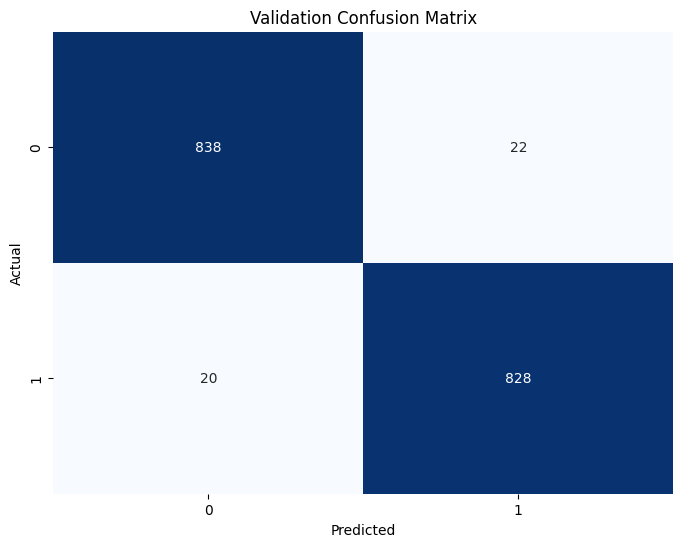

['XGB_without_missing_tuned.joblib']

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}


XGB_without_missing_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                     n_iter=50, cv=5, verbose=2, random_state=32,
                                     n_jobs=-1, scoring='f1')

XGB_without_missing_tuned.fit(X_train, y_train)

# get the best parameters from random search
print("Best parameters: ", XGB_without_missing_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", XGB_without_missing_tuned.best_score_)

# Validation
XGB_without_missing_tuned_val_pred = XGB_without_missing_tuned.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, XGB_without_missing_tuned_val_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_without_missing_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# save model
joblib.dump(XGB_without_missing_tuned, 'XGB_without_missing_tuned.joblib')

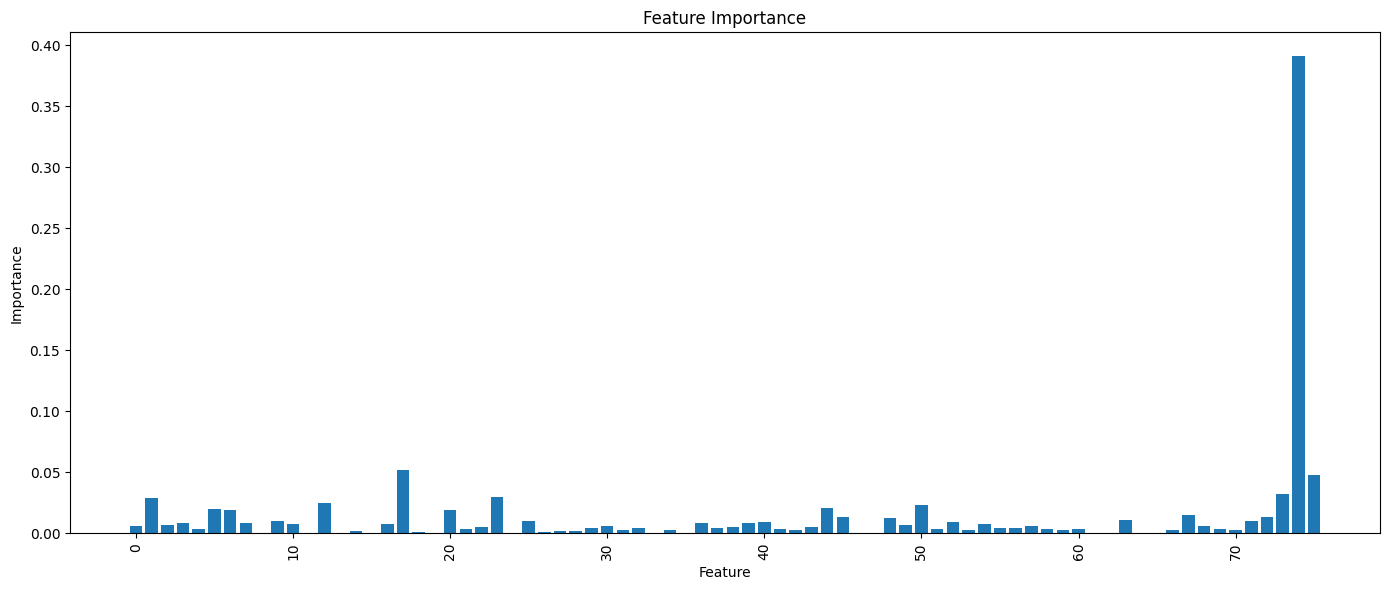

In [ ]:
# Plot feature importance scores for all features

feature_importances = XGB_without_missing_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Feature select from this tuned model

In [ ]:
XGB_without_missing_tuned

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200, 300],
                                        'random_state': [32],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=32, scoring='f1', verbose=2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Valdiation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       860
           1       0.98      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Valdiation Confusion Matrix:
[[839  21]
 [ 22 826]]


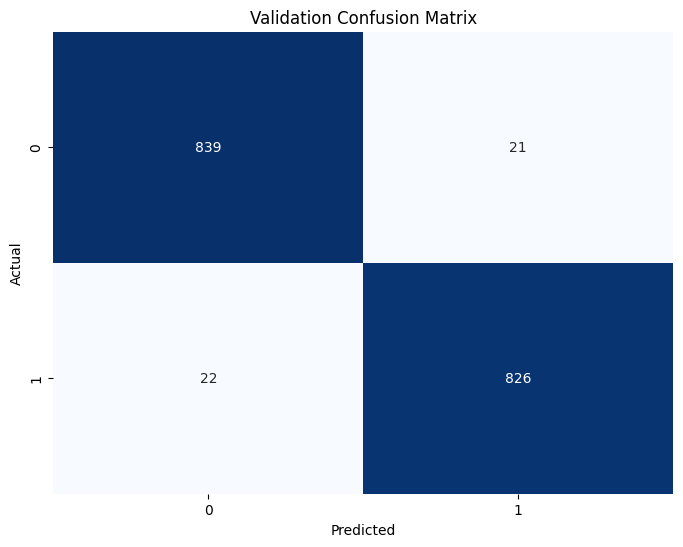

In [ ]:
# SelectFromModel
selector = SelectFromModel(XGB_without_missing_tuned.best_estimator_, threshold="median", prefit=True) # can add `max_features` to limit number of features
X_train_XGB_without_missing_tuned_fs = selector.transform(X_train)
X_val_XGB_without_missing_tuned_fs = selector.transform(X_val)
X_test_XGB_without_missing_tuned_fs = selector.transform(X_test)

# Retrain
XGB_without_missing_tuned_fs = xgb.XGBClassifier(**XGB_without_missing_tuned.best_params_, eval_metric='logloss', enable_categorical=True)
XGB_without_missing_tuned_fs.fit(X_train_XGB_without_missing_tuned_fs, y_train)

# Valdiation
XGB_without_missing_tuned_fs_val_pred = XGB_without_missing_tuned_fs.predict(X_val_XGB_without_missing_tuned_fs)
print("Valdiation Classification Report:")
print(classification_report(y_val, XGB_without_missing_tuned_fs_val_pred))

print("Valdiation Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_without_missing_tuned_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
selected_features = X_train.columns[selector.get_support()]
selected_importances = XGB_without_missing_tuned.best_estimator_.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_and',
       'nb_underscore', 'nb_percent', 'nb_slash', 'nb_colon', 'nb_space',
       'nb_www', 'http_in_path', 'ratio_digits_url', 'ratio_digits_host',
       'port', 'prefix_suffix', 'char_repeat', 'shortest_word_host',
       'shortest_word_path', 'longest_words_raw', 'avg_word_path',
       'phish_hints', 'domain_in_brand', 'suspecious_tld',
       'statistical_report', 'nb_hyperlinks', 'ratio_extHyperlinks',
       'ratio_extRedirection', 'external_favicon', 'safe_anchor',
       'domain_in_title', 'domain_with_copyright', 'domain_age', 'web_traffic',
       'dns_record', 'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


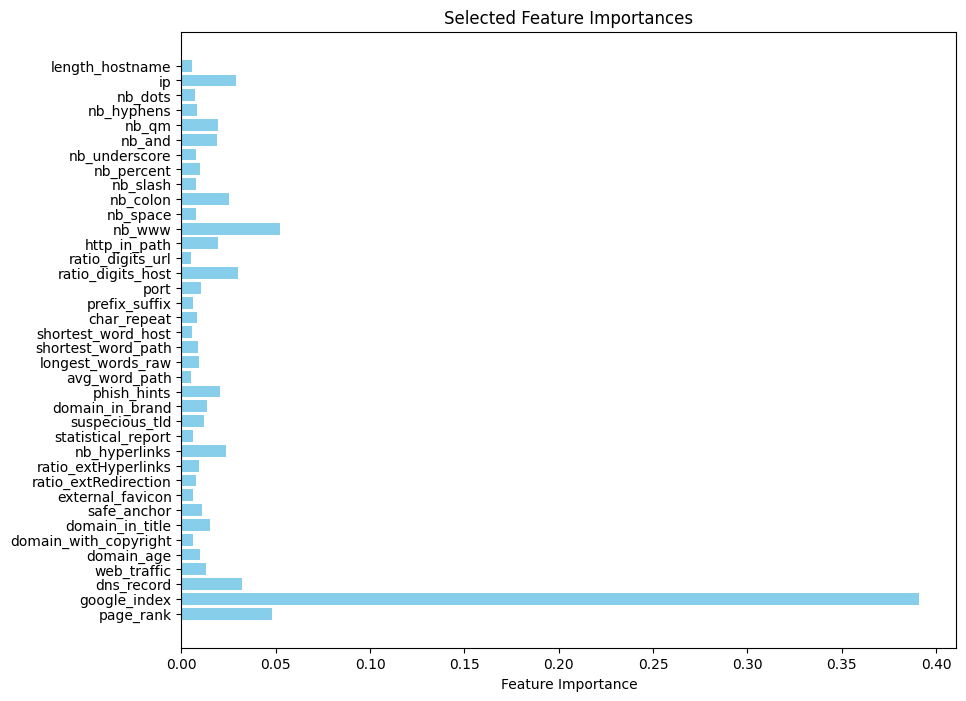

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### Tuned Model with high importance score features (selected from untuned model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
CV:  0.9668248001776879
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       860
           1       0.97      0.98      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[836  24]
 [ 21 827]]


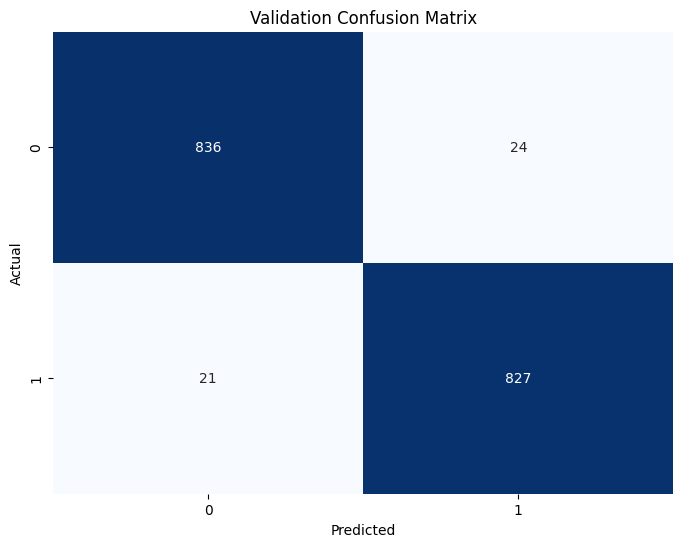

['XGB_without_missing_fs_tuned.joblib']

In [ ]:
# Tuning for model with all features
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_without_missing_fs_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                     n_iter=50, cv=5, verbose=2, random_state=32,
                                     n_jobs=-1, scoring='f1') ## ??? i might change to recall or smth idk yet

XGB_without_missing_fs_tuned.fit(X_train_XGB_without_missing_fs, y_train)

# get the best parameters from random search
print("Best parameters: ", XGB_without_missing_fs_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", XGB_without_missing_fs_tuned.best_score_)

# Validation
XGB_without_missing_fs_tuned_val_pred = XGB_without_missing_fs_tuned.predict(X_val_XGB_without_missing_fs)

print("Classification Report:")
print(classification_report(y_val, XGB_without_missing_fs_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_without_missing_fs_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(XGB_without_missing_fs_tuned, 'XGB_without_missing_fs_tuned.joblib')



### Tuned RFECV Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
CV:  0.9681814628494096
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[836  24]
 [ 25 823]]


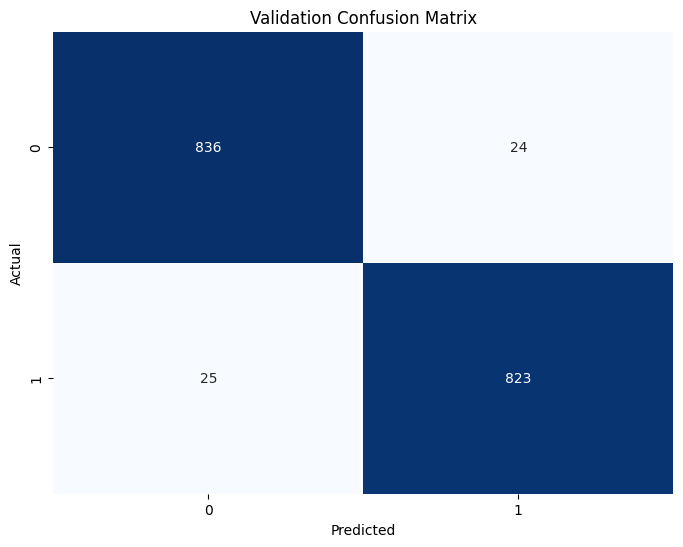

['XGB_without_missing_rfecv_tuned.joblib']

In [ ]:
# Tuning for RFECV-selected model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_without_missing_rfecv_tuned = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=32,
    n_jobs=-1,
    scoring='f1'
)

XGB_without_missing_rfecv_tuned.fit(X_train_XGB_without_missing_rfecv, y_train)
print("Best parameters: ", XGB_without_missing_rfecv_tuned.best_params_)
print("CV: ", XGB_without_missing_rfecv_tuned.best_score_)

xgb_rfecv_val_pred = XGB_without_missing_rfecv_tuned.predict(X_val_XGB_without_missing_rfecv)

print("Classification Report:")
print(classification_report(y_val, xgb_rfecv_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, xgb_rfecv_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the tuned model
joblib.dump(XGB_without_missing_rfecv_tuned, 'XGB_without_missing_rfecv_tuned.joblib')


## ANOVA

### Tuned Model with ANOVA feaures

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9658186881351737
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[831  29]
 [ 22 826]]


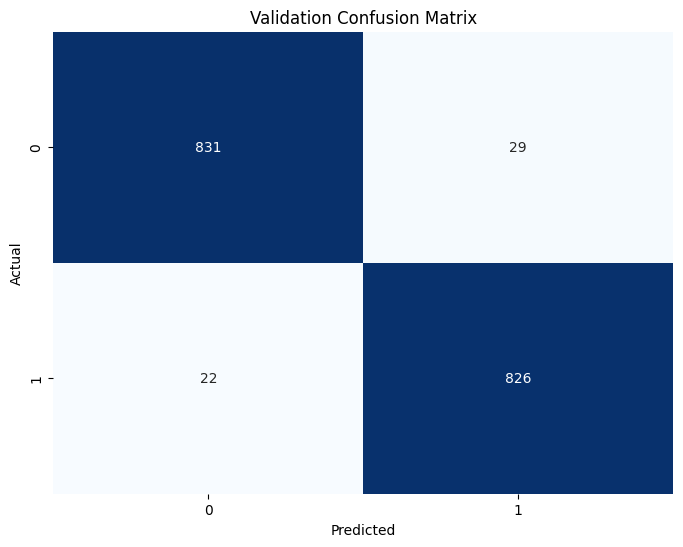

['XGB_anova_tuned.joblib']

In [ ]:
# Tuning for model with all features
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_anova_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                     n_iter=50, cv=5, verbose=2, random_state=32,
                                     n_jobs=-1, scoring='f1') ## ??? i might change to recall or smth idk yet

XGB_anova_tuned.fit(X_train_anova, y_train)

# get the best parameters from random search
print("Best parameters: ", XGB_anova_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", XGB_anova_tuned.best_score_)

# Validation Score
XGB_anova_tuned_val_pred = XGB_anova_tuned.predict(X_val_anova)

print("Classification Report:")
print(classification_report(y_val, XGB_anova_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_anova_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# save model
joblib.dump(XGB_anova_tuned, 'XGB_anova_tuned.joblib')


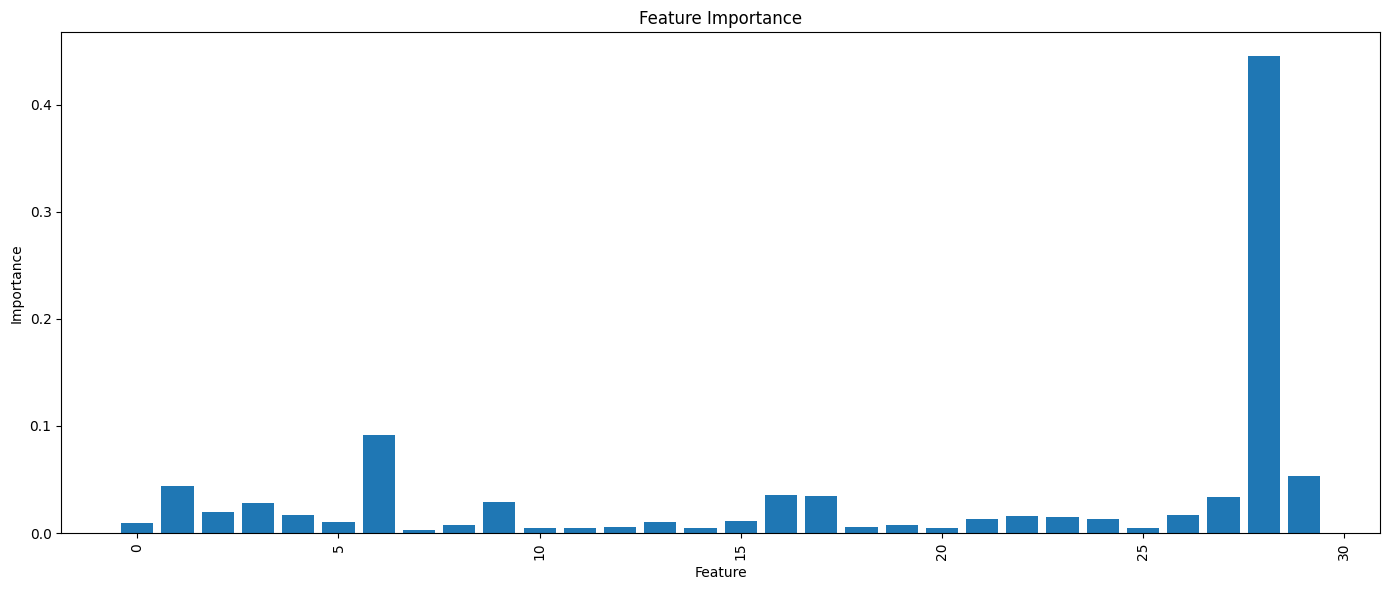

In [ ]:
# Plot feature importance scores for all features

feature_importances = XGB_anova_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## With Embeddings

### Tuned Model with all Features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
CV:  0.9689094579130499
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[837  23]
 [ 28 820]]


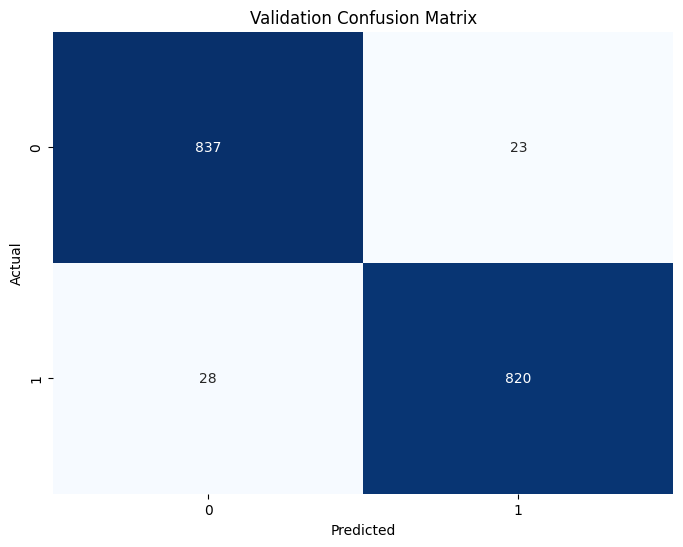

['XGB_emb_tuned.joblib']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_emb_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                     n_iter=50, cv=5, verbose=2, random_state=32,
                                     n_jobs=-1, scoring='f1')  # Adjust scoring as needed

XGB_emb_tuned.fit(X_train_emb, y_train)

# Get the best parameters from random search
print("Best parameters: ", XGB_emb_tuned.best_params_)
# Get evaluation metrics of CV scores of best parameters
print("CV: ", XGB_emb_tuned.best_score_)

# Validation
XGB_emb_tuned_val_pred = XGB_emb_tuned.predict(X_val_emb)

print("Classification Report:")
print(classification_report(y_val, XGB_emb_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_emb_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_emb_tuned, 'XGB_emb_tuned.joblib')


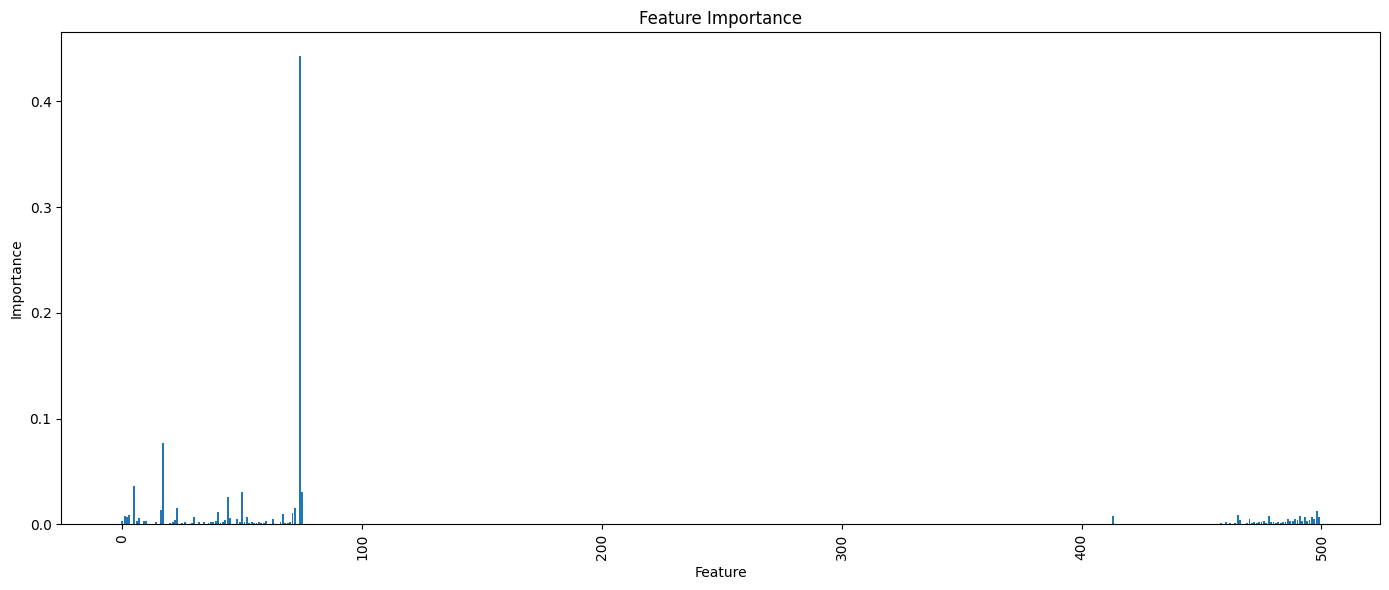

In [ ]:
# Plot feature importance scores for all features

feature_importances = XGB_emb_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Feature select from this tuned model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Validation Confusion Matrix:
[[837  23]
 [ 28 820]]


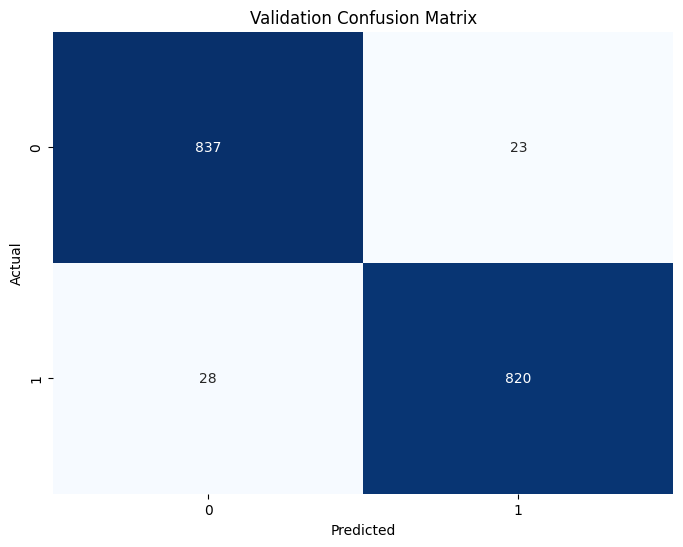

In [ ]:
# Feature Selection with SelectFromModel
selector = SelectFromModel(XGB_emb_tuned.best_estimator_, threshold="median", prefit=True)  # can add `max_features` to limit number of features
X_train_XGB_emb_tuned_fs = selector.transform(X_train_emb)
X_val_XGB_emb_tuned_fs = selector.transform(X_val_emb)
X_test_XGB_emb_tuned_fs = selector.transform(X_test_emb)  # Assuming you have this dataset

# Retrain on Selected Features
XGB_emb_tuned_fs = xgb.XGBClassifier(**XGB_emb_tuned.best_params_, eval_metric='logloss', enable_categorical=True)
XGB_emb_tuned_fs.fit(X_train_XGB_emb_tuned_fs, y_train)

# Validation
XGB_emb_tuned_fs_val_pred = XGB_emb_tuned_fs.predict(X_val_XGB_emb_tuned_fs)
print("Validation Classification Report:")
print(classification_report(y_val, XGB_emb_tuned_fs_val_pred))


print("Validation Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_emb_tuned_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
selected_features = X_train_emb.columns[selector.get_support()]
selected_importances = XGB_emb_tuned.best_estimator_.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm',
       'nb_and', 'nb_underscore', 'nb_tilde', 'nb_percent',
       ...
       '414', '415', '416', '417', '418', '419', '420', '421', '422', '423'],
      dtype='object', length=500)
Number of Features Selected: 500


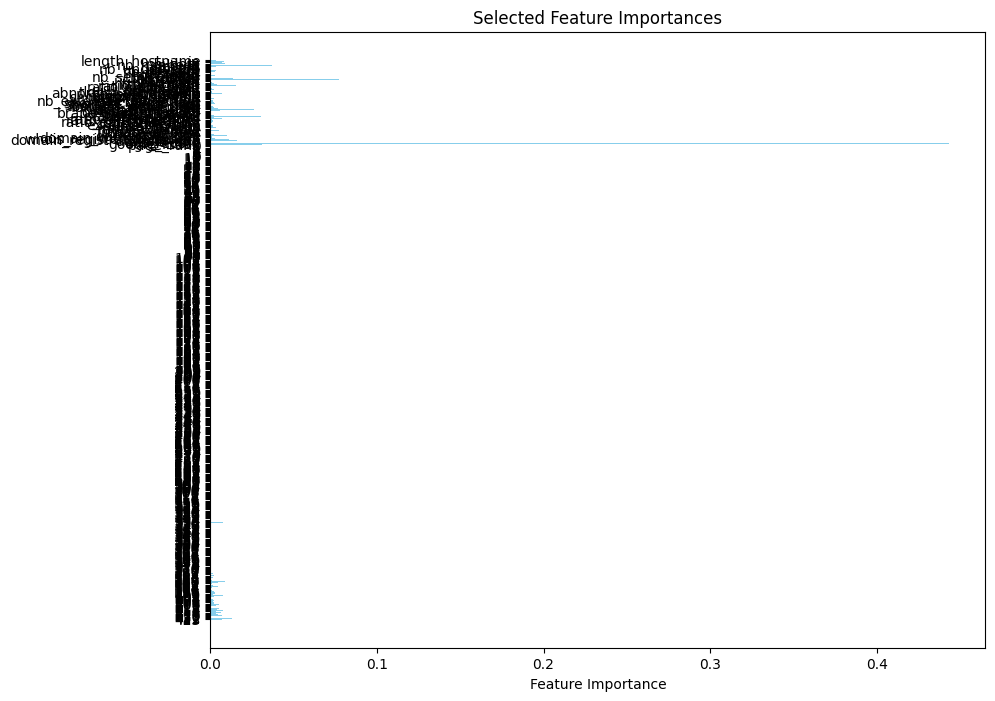

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### Tuned Model with high importance score features (selected from untuned model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
CV:  0.9689094579130499
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[837  23]
 [ 28 820]]


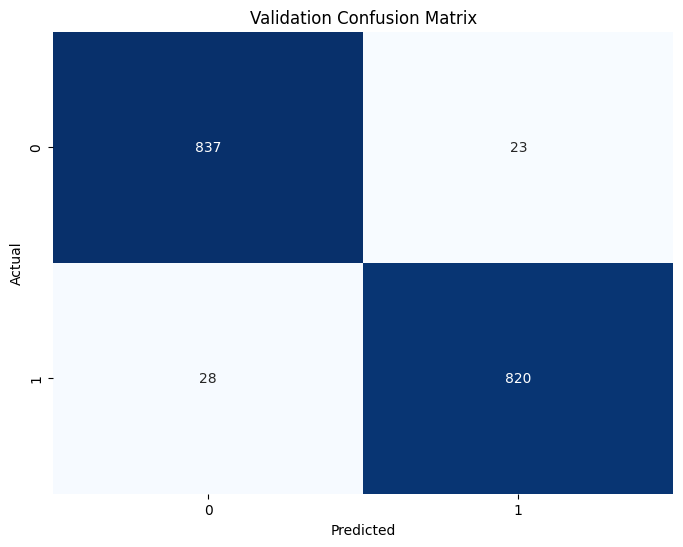

['XGB_emb_fs_tuned.joblib']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_emb_fs_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                       n_iter=50, cv=5, verbose=2, random_state=32,
                                       n_jobs=-1, scoring='f1')  # consider changing scoring if needed

XGB_emb_fs_tuned.fit(X_train_XGB_emb_tuned_fs, y_train)

# Get the best parameters from random search
print("Best parameters: ", XGB_emb_fs_tuned.best_params_)
print("CV: ", XGB_emb_fs_tuned.best_score_)

# Validation
XGB_emb_fs_tuned_val_pred = XGB_emb_fs_tuned.predict(X_val_XGB_emb_tuned_fs)


print("Classification Report:")
print(classification_report(y_val, XGB_emb_fs_tuned_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, XGB_emb_fs_tuned_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_emb_fs_tuned, 'XGB_emb_fs_tuned.joblib')

### Tuned RFECV Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9695577704224636
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       860
           1       0.98      0.97      0.97       848

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[840  20]
 [ 27 821]]


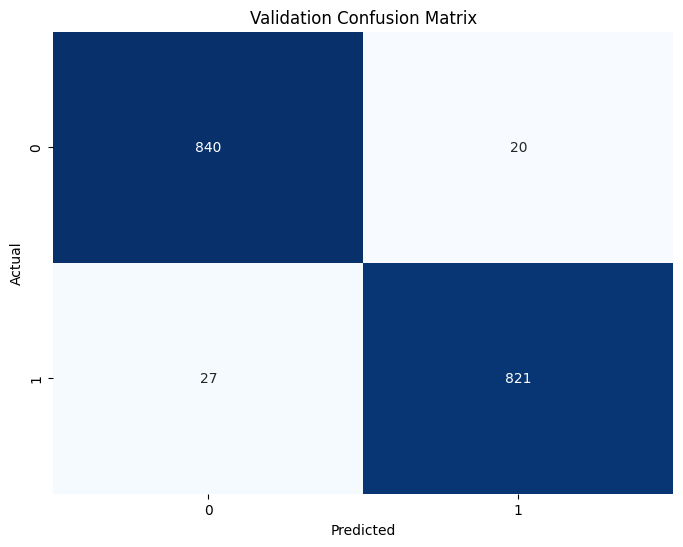

['XGB_emb_rfecv_tuned.joblib']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

XGB_emb_rfecv_tuned = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=32,
    n_jobs=-1,
    scoring='f1'
)

XGB_emb_rfecv_tuned.fit(X_train_XGB_emb_rfecv, y_train)

# Get the best parameters from random search
print("Best parameters: ", XGB_emb_rfecv_tuned.best_params_)
print("CV: ", XGB_emb_rfecv_tuned.best_score_)

# Validation Predictions
xgb_rfecv_val_pred = XGB_emb_rfecv_tuned.predict(X_val_XGB_emb_rfecv)


print("Classification Report:")
print(classification_report(y_val, xgb_rfecv_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, xgb_rfecv_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the tuned model
joblib.dump(XGB_emb_rfecv_tuned, 'XGB_emb_rfecv_tuned.joblib')

## With Encodings

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (Regular Encoded):  {'subsample': 0.8, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
CV Score (Regular Encoded):  0.940731923693616
Classification Report (Validation - Regular Encoded):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       860
           1       0.94      0.93      0.94       848

    accuracy                           0.94      1708
   macro avg       0.94      0.94      0.94      1708
weighted avg       0.94      0.94      0.94      1708

Confusion Matrix (Validation - Regular Encoded):


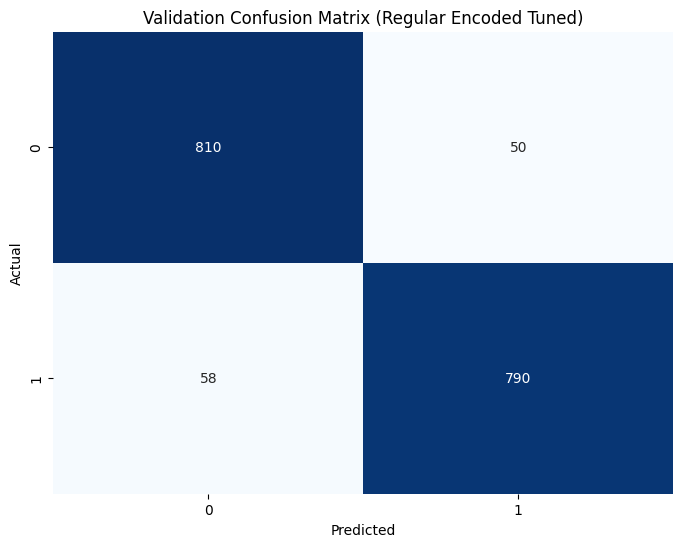

['XGB_encoded_tuned.joblib']

In [ ]:

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

# Initialize RandomizedSearchCV for XGBoost using regular encoded dataset
XGB_encoded_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                        n_iter=50, cv=5, verbose=2, random_state=32,
                                        n_jobs=-1, scoring='f1')  # You can change scoring to 'recall' if needed

# Fit the model
XGB_encoded_tuned.fit(X_train_encoded, y_train)

# Get the best parameters from random search
print("Best parameters (Regular Encoded): ", XGB_encoded_tuned.best_params_)
# Get evaluation metrics of cv scores of best parameters
print("CV Score (Regular Encoded): ", XGB_encoded_tuned.best_score_)

# Validation Score
XGB_encoded_tuned_val_pred = XGB_encoded_tuned.predict(X_val_encoded)


print("Classification Report (Validation - Regular Encoded):")
print(classification_report(y_val, XGB_encoded_tuned_val_pred))


print("Confusion Matrix (Validation - Regular Encoded):")
cm_encoded_val_tuned = confusion_matrix(y_val, XGB_encoded_tuned_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_encoded_val_tuned, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Regular Encoded Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_encoded_tuned, 'XGB_encoded_tuned.joblib')


## With Embeddings + Encoding

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (Embedded Encoded):  {'subsample': 0.8, 'random_state': 32, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
CV Score (Embedded Encoded):  0.9400648977248434
Classification Report (Validation - Embedded Encoded):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       860
           1       0.95      0.92      0.93       848

    accuracy                           0.93      1708
   macro avg       0.93      0.93      0.93      1708
weighted avg       0.93      0.93      0.93      1708

Confusion Matrix (Validation - Embedded Encoded):


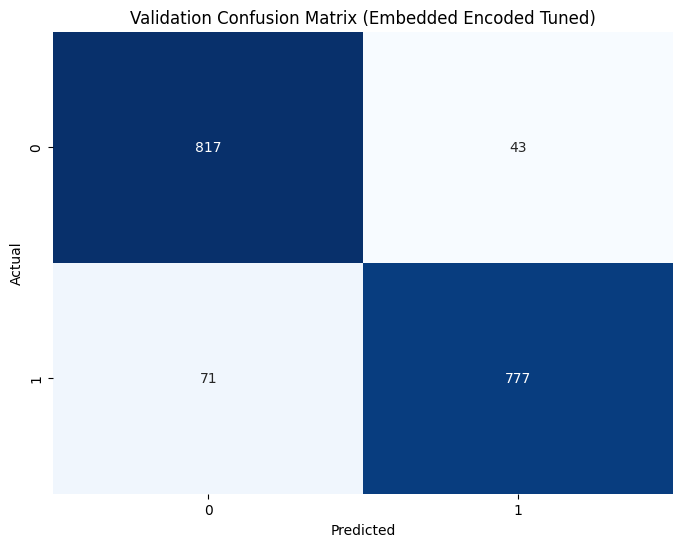

['XGB_emb_encoded_tuned.joblib']

In [ ]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

# Initialize RandomizedSearchCV for XGBoost using embedded encoded dataset
XGB_emb_encoded_tuned = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=param_grid,
                                            n_iter=50, cv=5, verbose=2, random_state=32,
                                            n_jobs=-1, scoring='f1')  # You can change scoring to 'recall' if needed

# Fit the model
XGB_emb_encoded_tuned.fit(X_train_emb_encoded, y_train)

# Get the best parameters from random search
print("Best parameters (Embedded Encoded): ", XGB_emb_encoded_tuned.best_params_)
# Get evaluation metrics of cv scores of best parameters
print("CV Score (Embedded Encoded): ", XGB_emb_encoded_tuned.best_score_)

# Validation Score
XGB_emb_encoded_tuned_val_pred = XGB_emb_encoded_tuned.predict(X_val_emb_encoded)


print("Classification Report (Validation - Embedded Encoded):")
print(classification_report(y_val, XGB_emb_encoded_tuned_val_pred))


print("Confusion Matrix (Validation - Embedded Encoded):")
cm_emb_val_tuned = confusion_matrix(y_val, XGB_emb_encoded_tuned_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_val_tuned, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Embedded Encoded Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(XGB_emb_encoded_tuned, 'XGB_emb_encoded_tuned.joblib')


# LightGBM Hyperparameter Tuning

## All features (without_missing)

### Tuned Model with all Features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4370
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9681655144582567
Classification Report:
              precision    r

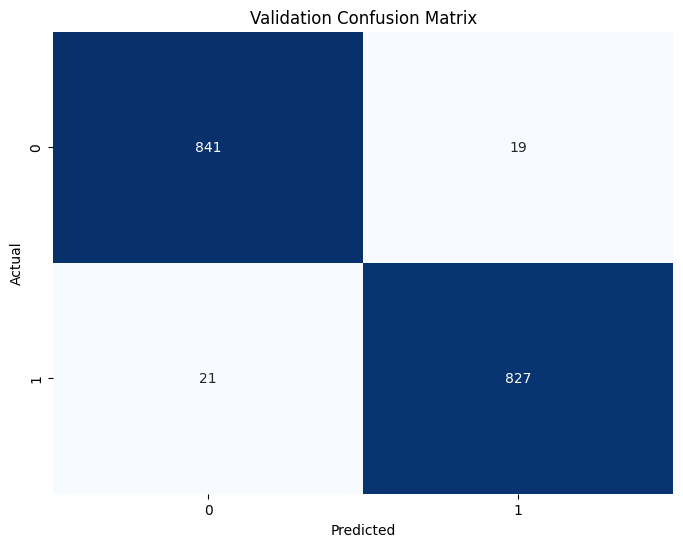

['LGB_without_missing_tuned.joblib']

In [ ]:
# Tuning for model with all features
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves':[15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}


LGB_without_missing_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                      n_iter=50, cv=5, verbose=2,
                                      random_state=32, n_jobs=-1, scoring='f1')

LGB_without_missing_tuned.fit(X_train, y_train)

# get the best parameters from random search
print("Best parameters: ", LGB_without_missing_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", LGB_without_missing_tuned.best_score_)

# Validation Score
LGB_without_missing_tuned_val_pred = LGB_without_missing_tuned.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, LGB_without_missing_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_without_missing_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(LGB_without_missing_tuned, 'LGB_without_missing_tuned.joblib')


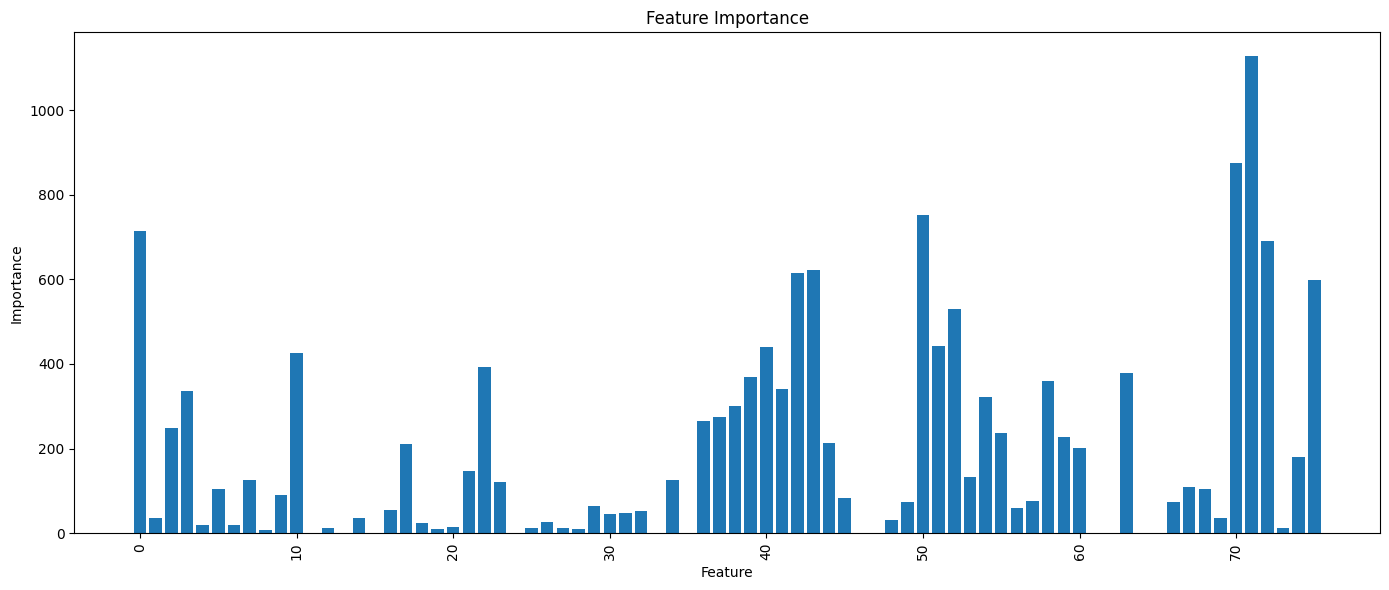

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_without_missing_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Feature select from this tuned model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4265
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       860
           1       0.98      0.98      0.98       848

    accuracy                           0.98      1708
   macro avg       0.98      0.98      0.98      1708
weighted avg       0.98      0.98      0.98      1708

Confusion Matrix:
[[839  21]
 [ 19 829]]


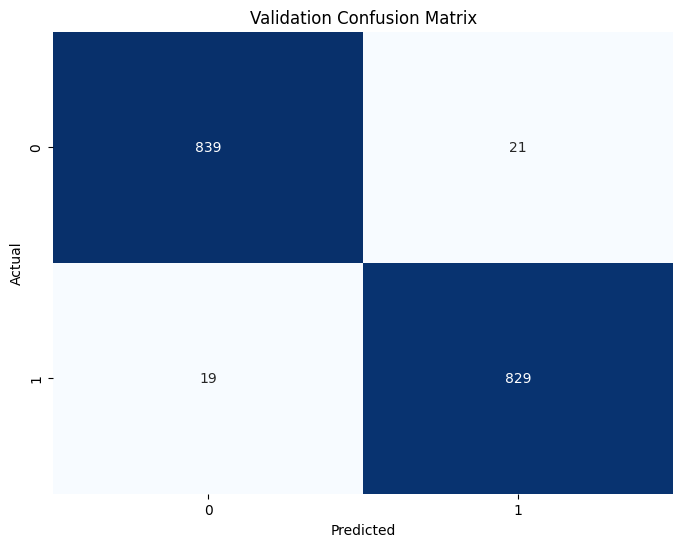

['LGB_without_missing_tuned_fs.joblib']

In [ ]:
# Feature Selection with SelectFromModel
selector = SelectFromModel(LGB_without_missing_tuned.best_estimator_, threshold="median", prefit=True) # can add `max_features` to limit number of features
X_train_LGB_without_missing_tuned_fs = selector.transform(X_train)
X_val_lgb_without_missing_tuned_fs= selector.transform(X_val)
X_test_lgb_without_missing_tuned_fs = selector.transform(X_test)

LGB_without_missing_tuned_fs = lgb.LGBMClassifier(**LGB_without_missing_tuned.best_params_) #include early stopping when we tune
# LGB_without_missing_tuned_fs.__init__(boosting_type='gbdt')
LGB_without_missing_tuned_fs.fit(X_train_LGB_without_missing_tuned_fs, y_train)

# Validation Score
LGB_without_missing_tuned_fs_val_pred = LGB_without_missing_tuned_fs.predict(X_val_lgb_without_missing_tuned_fs)

print("Classification Report:")
print(classification_report(y_val, LGB_without_missing_tuned_fs_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_without_missing_tuned_fs_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
# save model
joblib.dump(LGB_without_missing_tuned_fs, 'LGB_without_missing_tuned_fs.joblib')


In [ ]:
selected_features = X_train.columns[selector.get_support()]
selected_importances = LGB_without_missing_tuned.best_estimator_.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_underscore',
       'nb_percent', 'nb_slash', 'nb_www', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'nb_redirection', 'char_repeat',
       'shortest_words_raw', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_host', 'avg_words_raw',
       'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


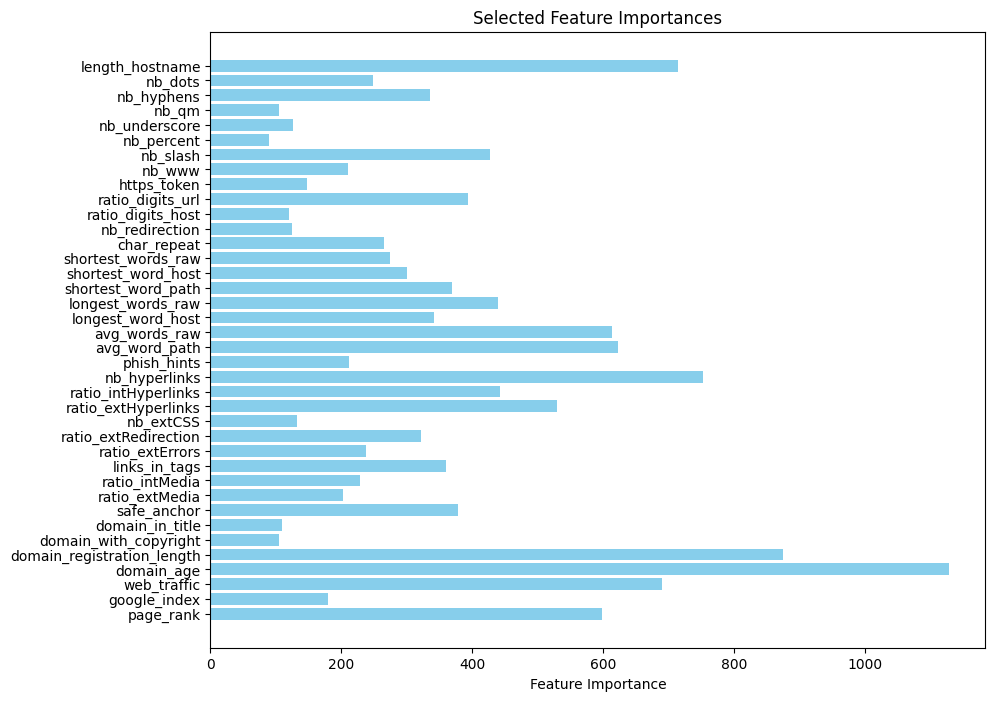

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### Tuned Model with high importance score features (selected from untuned model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4250
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV:  0.9693447687278061
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       860
           1       0.98      0.97      0.97       848

    accuracy  

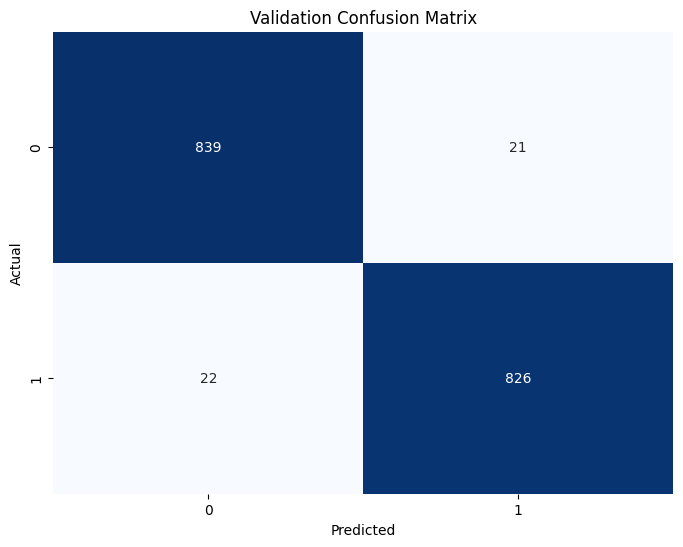

['LGB_without_missing_fs_tuned.joblib']

In [ ]:
# Tuning for model with all features
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves':[15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

LGB_without_missing_fs_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                      n_iter=50, cv=5, verbose=2,
                                      random_state=32, n_jobs=-1, scoring='f1')

LGB_without_missing_fs_tuned.fit(X_train_LGB_without_missing_fs, y_train)

# get the best parameters from random search
print("Best parameters: ", LGB_without_missing_fs_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", LGB_without_missing_fs_tuned.best_score_)

# Validation Score
LGB_without_missing_fs_tuned_val_pred = LGB_without_missing_fs_tuned.predict(X_val_LGB_without_missing_fs)

print("Classification Report:")
print(classification_report(y_val, LGB_without_missing_fs_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_without_missing_fs_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(LGB_without_missing_fs_tuned, 'LGB_without_missing_fs_tuned.joblib')



### Tuned RFECV Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4277
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters for RFECV-selected model:  {'subsample': 0.6, 'random_state': 32, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
CV Score:  0.9695527089672051
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       860
           1       0.97      0.98     

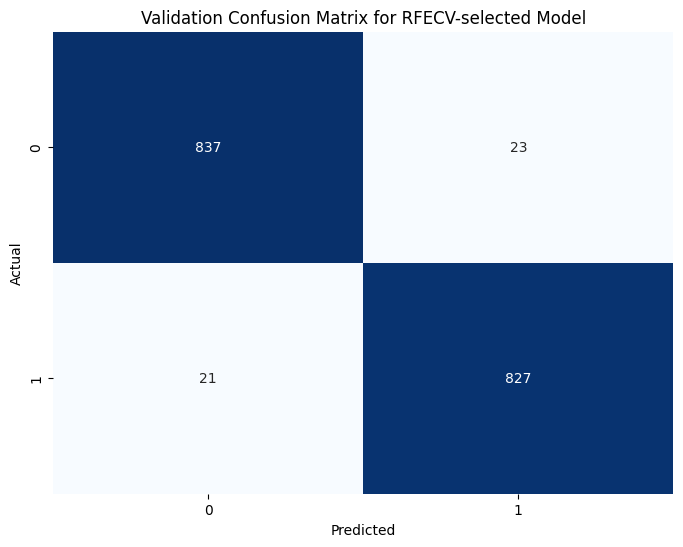

['LightGBM_without_missing_rfecv_tuned.joblib']

In [ ]:
# Tuning for model with RFECV-selected features
param_grid_rfecv = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

LightGBM_without_missing_rfecv_tuned = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=param_grid_rfecv,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=32,
    n_jobs=-1,
    scoring='f1'
)

# Fit the tuned model on RFECV-selected features
LightGBM_without_missing_rfecv_tuned.fit(X_train_LGB_without_missing_rfecv, y_train)

# Get the best parameters from random search
print("Best parameters for RFECV-selected model: ", LightGBM_without_missing_rfecv_tuned.best_params_)
# Get evaluation metrics of CV scores of best parameters
print("CV Score: ", LightGBM_without_missing_rfecv_tuned.best_score_)

# Validation Score
LightGBM_rfecv_val_pred = LightGBM_without_missing_rfecv_tuned.predict(X_val_LGB_without_missing_rfecv)

print("Classification Report:")
print(classification_report(y_val, LightGBM_rfecv_val_pred))

print("Confusion Matrix:")
cm_rfecv = confusion_matrix(y_val, LightGBM_rfecv_val_pred)
print(cm_rfecv)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfecv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for RFECV-selected Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the tuned model for RFECV-selected features
joblib.dump(LightGBM_without_missing_rfecv_tuned, 'LightGBM_without_missing_rfecv_tuned.joblib')


## ANOVA

### Tuned Model with ANOVA feaures

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3121
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9674414240244407
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       860
           1       0.97      0.97      0.97       848

    accuracy  

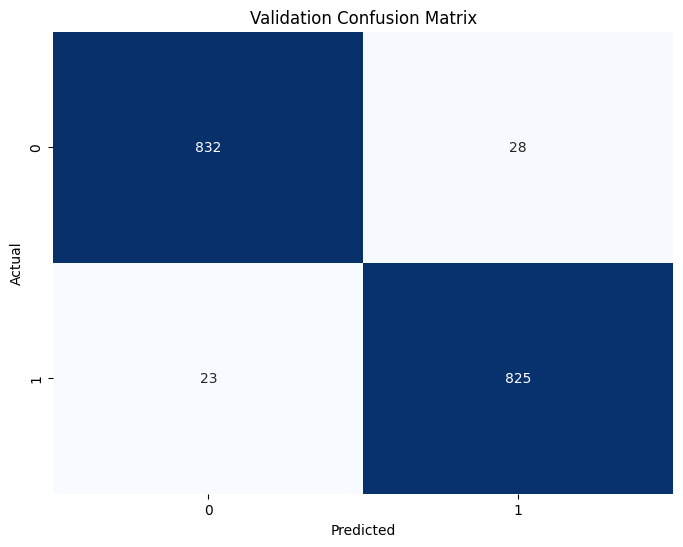

['LGB_anova_tuned.joblib']

In [ ]:
# Tuning for model with all features
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves':[15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}


LGB_anova_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                      n_iter=50, cv=5, verbose=2,
                                      random_state=32, n_jobs=-1, scoring='f1')
LGB_anova_tuned.fit(X_train_anova, y_train)

# get the best parameters from random search
print("Best parameters: ", LGB_anova_tuned.best_params_)
# get evaluation metrics of cv scores of best parameters
print("CV: ", LGB_anova_tuned.best_score_)

# Validation Score
LGB_anova_tuned_val_pred = LGB_anova_tuned.predict(X_val_anova)
print("Classification Report:")
print(classification_report(y_val, LGB_anova_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_anova_tuned_val_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# save model
joblib.dump(LGB_anova_tuned, 'LGB_anova_tuned.joblib')

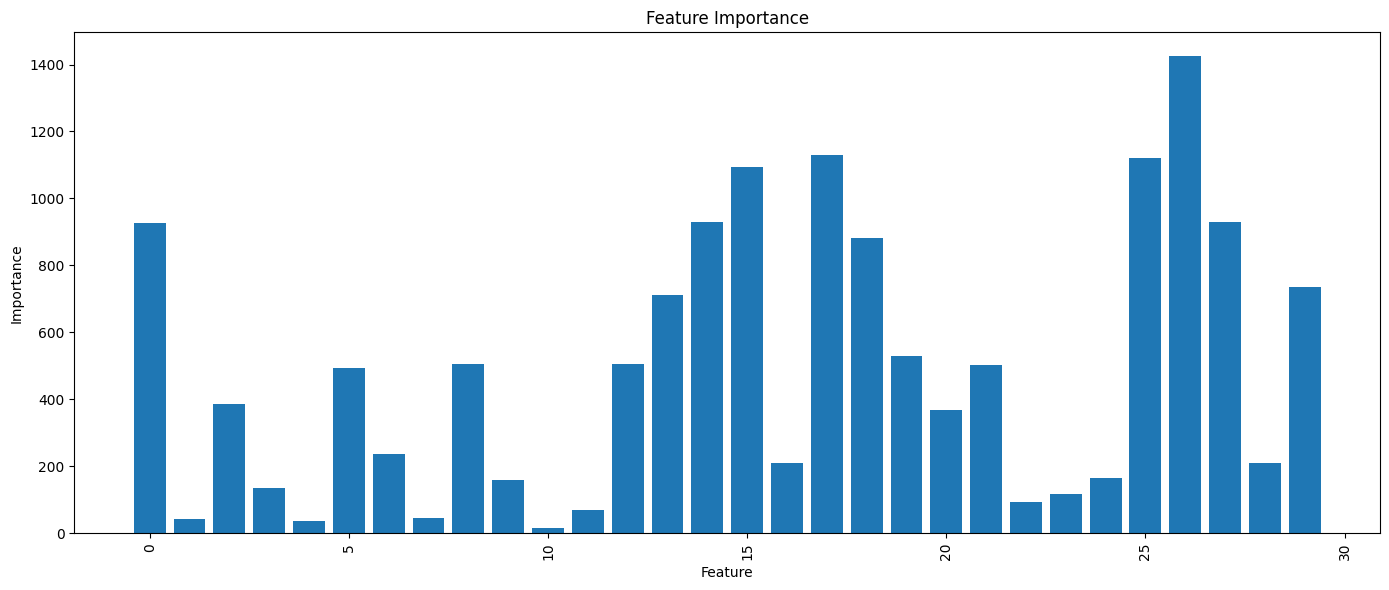

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_anova_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


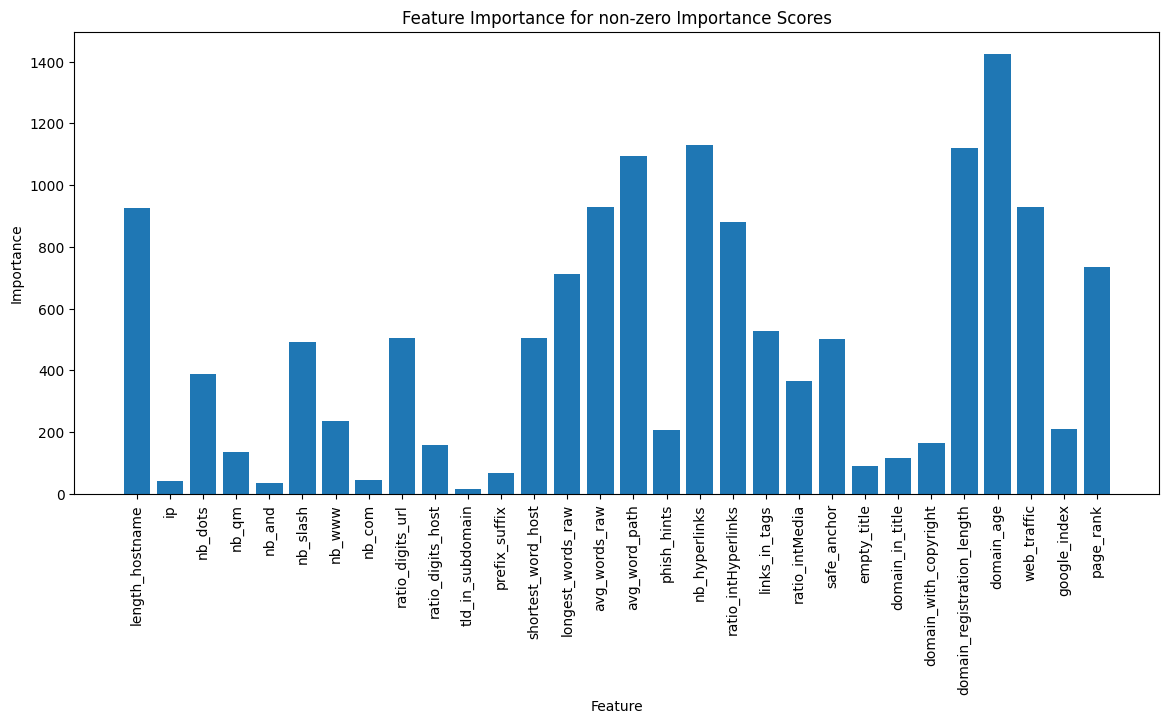

In [ ]:
# removed the features that have a feature score of 0
non_zero_feature_importances = [importance for importance in feature_importances if importance > 0]

# indices of non-zero features
non_zero_feature_indices = [index for index, importance in enumerate(feature_importances) if importance > 0]

# names of non-zero features
non_zero_feature_names = [X_train_anova.columns[index] for index in non_zero_feature_indices]

plt.figure(figsize=(14, 6))
plt.bar(range(len(non_zero_feature_importances)), non_zero_feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for non-zero Importance Scores')
plt.xticks(range(len(non_zero_feature_importances)), non_zero_feature_names, rotation=90)

plt.show()


## With Embeddings

### Tuned Model with all Features

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4370
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV:  0.9681655144582567
Classification Report:
              precision    r

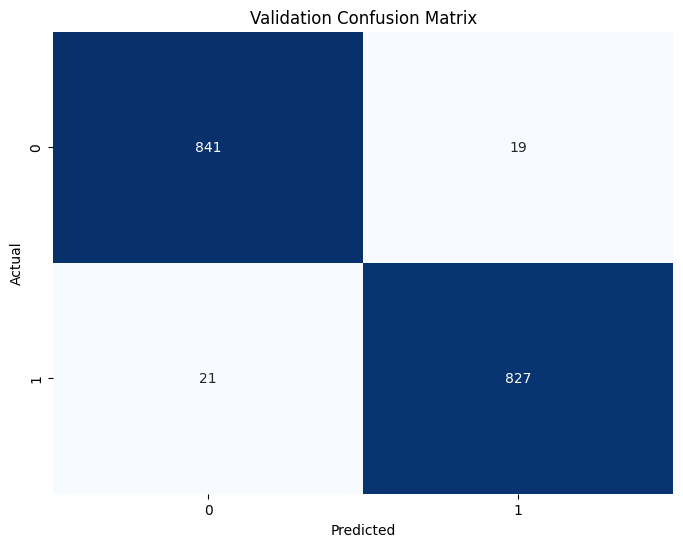

['LGB_emb_tuned.joblib']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

LGB_emb_tuned = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=32,
    n_jobs=-1,
    scoring='f1'
)

LGB_emb_tuned.fit(X_train, y_train)

# Get the best parameters from random search
print("Best parameters: ", LGB_emb_tuned.best_params_)
print("CV: ", LGB_emb_tuned.best_score_)

# Validation
LGB_emb_tuned_val_pred = LGB_emb_tuned.predict(X_val)

print("Classification Report:")
print(classification_report(y_val, LGB_emb_tuned_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_emb_tuned_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_emb_tuned, 'LGB_emb_tuned.joblib')

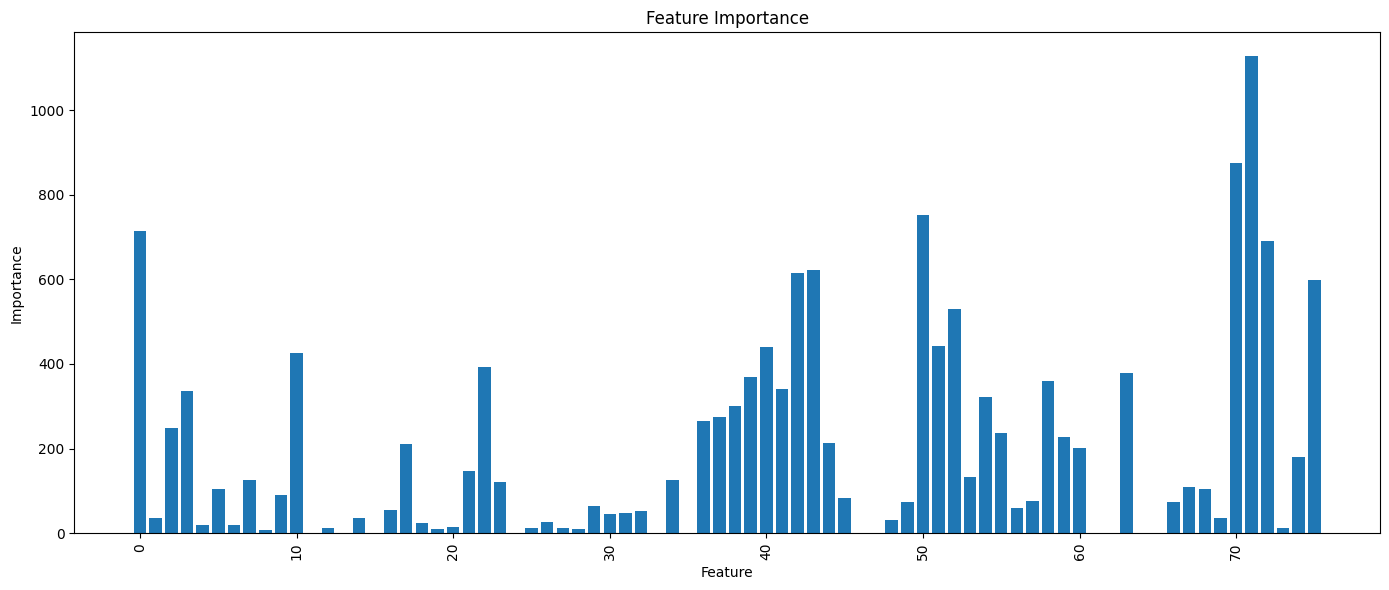

In [ ]:
# Plot feature importance scores for all features

feature_importances = LGB_emb_tuned.best_estimator_.feature_importances_
plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Feature select from this tuned model

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4265
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       860
           1       0.98      0.98      0.98       848

    accuracy                           0.98      1708
   macro avg       0.98      0.98      0.98      1708
weighted avg       0.98      0.98      0.98      1708

Confusion Matrix:
[[839  21]
 [ 19 829]]


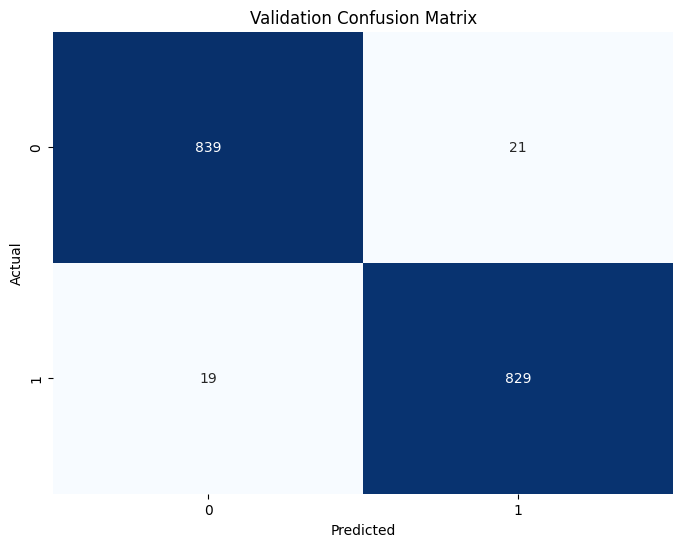

['LGB_emb_tuned_fs.joblib']

In [ ]:
selector = SelectFromModel(LGB_emb_tuned.best_estimator_, threshold="median", prefit=True)  # can add `max_features` to limit number of features
X_train_LGB_emb_tuned_fs = selector.transform(X_train)
X_val_LGB_emb_tuned_fs = selector.transform(X_val)
X_test_LGB_emb_tuned_fs = selector.transform(X_test)

LGB_emb_tuned_fs = lgb.LGBMClassifier(**LGB_emb_tuned.best_params_)
LGB_emb_tuned_fs.fit(X_train_LGB_emb_tuned_fs, y_train)

# Validation Score
LGB_emb_tuned_fs_val_pred = LGB_emb_tuned_fs.predict(X_val_LGB_emb_tuned_fs)

print("Classification Report:")
print(classification_report(y_val, LGB_emb_tuned_fs_val_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_emb_tuned_fs_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_emb_tuned_fs, 'LGB_emb_tuned_fs.joblib')

In [ ]:
selected_features = X_train_emb.columns[selector.get_support()]
selected_importances = LGB_emb_tuned.best_estimator_.feature_importances_[selector.get_support()]
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_underscore',
       'nb_percent', 'nb_slash', 'nb_www', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'nb_redirection', 'char_repeat',
       'shortest_words_raw', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_host', 'avg_words_raw',
       'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


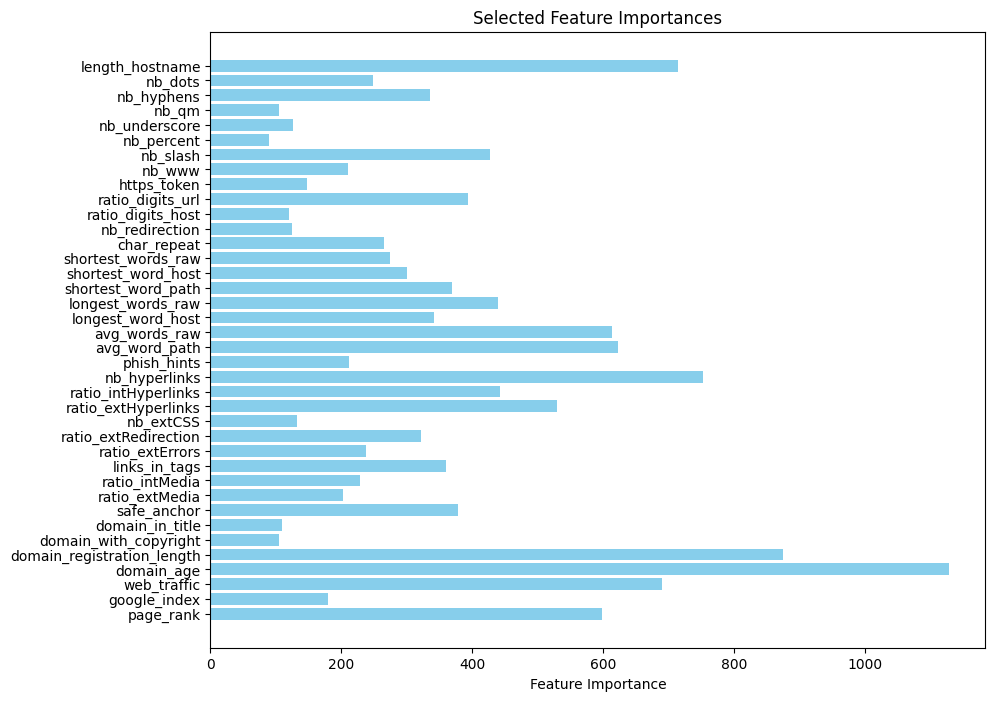

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

### Tuned Model with high importance score features (selected from untuned model)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4250
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV:  0.9693447687278061
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       860
           1       0.98      0.97      0.97       848

    accuracy  

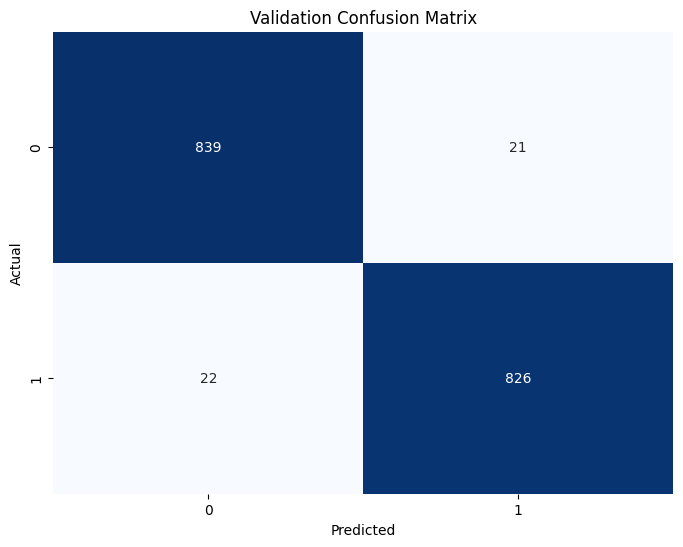

['LGB_emb_fs_tuned.joblib']

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

LGB_emb_fs_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                       n_iter=50, cv=5, verbose=2,
                                       random_state=32, n_jobs=-1, scoring='f1')

LGB_emb_fs_tuned.fit(X_train_LGB_without_missing_fs, y_train)

# Get the best parameters from random search
print("Best parameters: ", LGB_emb_fs_tuned.best_params_)
# Get evaluation metrics of CV scores of best parameters
print("CV: ", LGB_emb_fs_tuned.best_score_)

# Validation Score
LGB_emb_fs_tuned_val_pred = LGB_emb_fs_tuned.predict(X_val_LGB_without_missing_fs)


print("Classification Report:")
print(classification_report(y_val, LGB_emb_fs_tuned_val_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_val, LGB_emb_fs_tuned_val_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_emb_fs_tuned, 'LGB_emb_fs_tuned.joblib')

### Tuned RFECV Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10315
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters for RFECV-selected model:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV Score:  0.9706421236221863
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       860
           1       0.97      0.98    

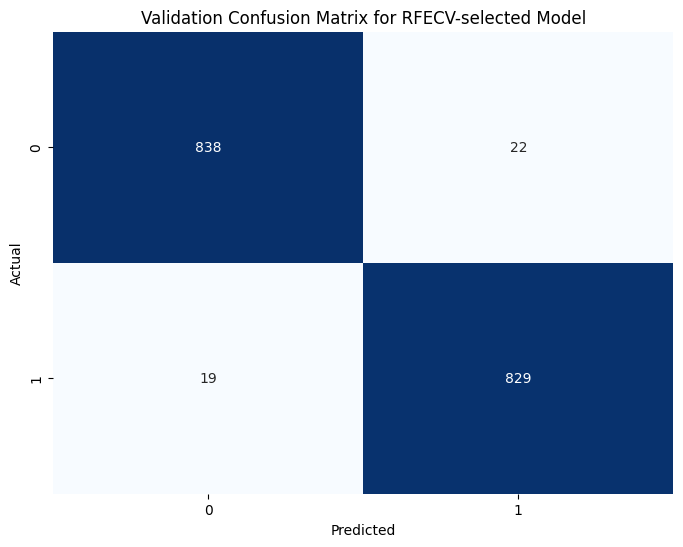

['LGB_emb_rfecv_tuned.joblib']

In [ ]:
# Tuning for model with RFECV-selected features
param_grid_rfecv = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

LGB_emb_rfecv_tuned = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(),
    param_distributions=param_grid_rfecv,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=32,
    n_jobs=-1,
    scoring='f1'
)

# Fit the tuned model on RFECV-selected features
LGB_emb_rfecv_tuned.fit(X_train_LGB_emb_rfecv, y_train)

# Get the best parameters from random search
print("Best parameters for RFECV-selected model: ", LGB_emb_rfecv_tuned.best_params_)
# Get evaluation metrics of CV scores of best parameters
print("CV Score: ", LGB_emb_rfecv_tuned.best_score_)

# Validation Score
LGB_rfecv_val_pred = LGB_emb_rfecv_tuned.predict(X_val_LGB_emb_rfecv)

print("Classification Report:")
print(classification_report(y_val, LGB_rfecv_val_pred))

print("Confusion Matrix:")
cm_rfecv = confusion_matrix(y_val, LGB_rfecv_val_pred)
print(cm_rfecv)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rfecv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix for RFECV-selected Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the tuned model for RFECV-selected features
joblib.dump(LGB_emb_rfecv_tuned, 'LGB_emb_rfecv_tuned.joblib')


## With Encodings

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters (Regular Encoded):  {'subsample': 0.8, 'random_state': 32, 'num_leaves': 15, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
CV Score (Regular Encoded):  0.9401076101294003
Classification Report (Validation - Regular Encoded):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       860
           1       0.94      0.93      0.94       848

    a

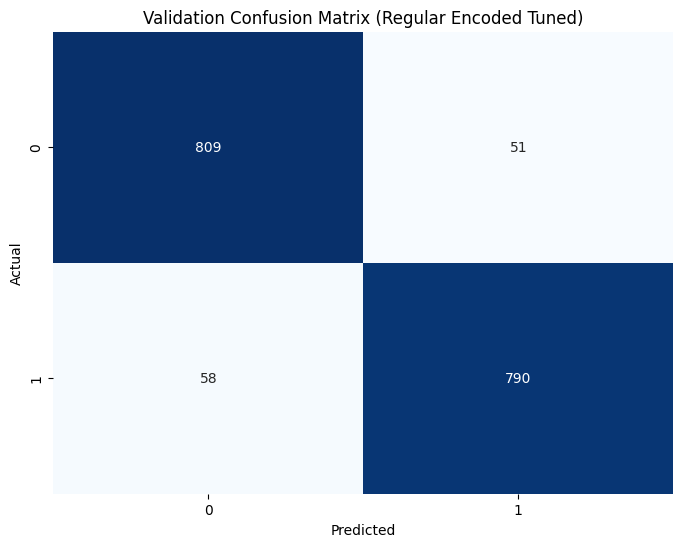

['LGB_encoded_tuned.joblib']

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

# Initialize RandomizedSearchCV for LightGBM using regular encoded dataset
LGB_encoded_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                        n_iter=50, cv=5, verbose=2,
                                        random_state=32, n_jobs=-1, scoring='f1')

# Fit the model
LGB_encoded_tuned.fit(X_train_encoded, y_train)

# Get the best parameters from random search
print("Best parameters (Regular Encoded): ", LGB_encoded_tuned.best_params_)
# Get evaluation metrics of cv scores of best parameters
print("CV Score (Regular Encoded): ", LGB_encoded_tuned.best_score_)

# Validation Score
LGB_encoded_tuned_val_pred = LGB_encoded_tuned.predict(X_val_encoded)

print("Classification Report (Validation - Regular Encoded):")
print(classification_report(y_val, LGB_encoded_tuned_val_pred))


print("Confusion Matrix (Validation - Regular Encoded):")
cm_encoded_val_tuned = confusion_matrix(y_val, LGB_encoded_tuned_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_encoded_val_tuned, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Regular Encoded Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_encoded_tuned, 'LGB_encoded_tuned.joblib')


## With Embeddings + Encoding

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 4002, number of negative: 3966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 7968, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502259 -> initscore=0.009036
[LightGBM] [Info] Start training from score 0.009036
Best parameters (Embedded Encoded):  {'subsample': 0.8, 'random_state': 32, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
CV Score (Embedded Encoded):  0.938933887804916
Classification Report (Validation - Embedded Encoded):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       860
           1       0.95      0.92      0.93       848

   

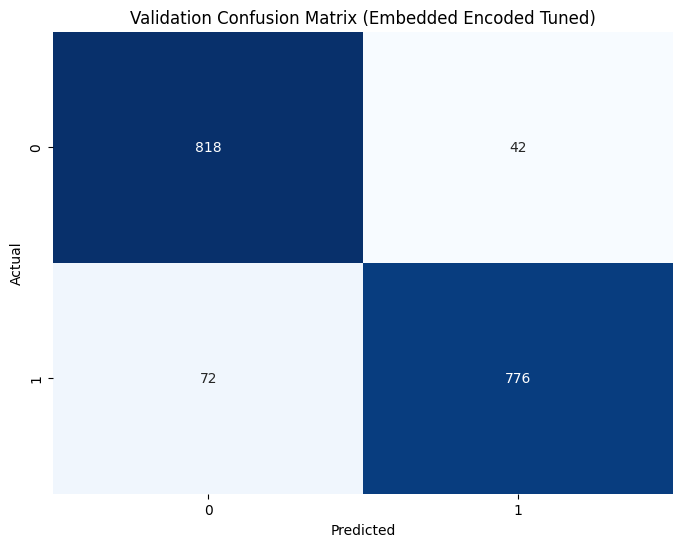

['LGB_emb_encoded_tuned.joblib']

In [ ]:

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [15, 31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'random_state': [32]
}

# Initialize RandomizedSearchCV for LightGBM using embedded encoded dataset
LGB_emb_encoded_tuned = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_grid,
                                           n_iter=50, cv=5, verbose=2,
                                           random_state=32, n_jobs=-1, scoring='f1')

# Fit the model
LGB_emb_encoded_tuned.fit(X_train_emb_encoded, y_train)

# Get the best parameters from random search
print("Best parameters (Embedded Encoded): ", LGB_emb_encoded_tuned.best_params_)
# Get evaluation metrics of cv scores of best parameters
print("CV Score (Embedded Encoded): ", LGB_emb_encoded_tuned.best_score_)

# Validation Score
LGB_emb_encoded_tuned_val_pred = LGB_emb_encoded_tuned.predict(X_val_emb_encoded)

print("Classification Report (Validation - Embedded Encoded):")
print(classification_report(y_val, LGB_emb_encoded_tuned_val_pred))

print("Confusion Matrix (Validation - Embedded Encoded):")
cm_emb_val_tuned = confusion_matrix(y_val, LGB_emb_encoded_tuned_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_emb_val_tuned, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix (Embedded Encoded Tuned)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save model
joblib.dump(LGB_emb_encoded_tuned, 'LGB_emb_encoded_tuned.joblib')


# Best Model trained on Train + Val set to predict Test Set
Model selection using the Validation F1 Scores across models concluded that the best performing model was the LightGBM model that was firstly fitted on the entire `without_missing` dataset and tuned, then feature selected using the innate feature importance scores of LightGBM.

**Selected Features** are: Index(['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_underscore',
       'nb_percent', 'nb_slash', 'nb_www', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'nb_redirection', 'char_repeat',
       'shortest_words_raw', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_host', 'avg_words_raw',
       'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38

**Best parameters**:  {'subsample': 1.0, 'random_state': 32, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

Therefore, to make the model more robust, we now train the LightGBM model on the combined trained and validation set with the above features and best parameters. This model will the be used to predict for the test set which will enable us to evaluate the final performance.

In [ ]:
X_train_combined = pd.concat([X_train, X_val])
X_train_combined.head(5)

,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_underscore,nb_tilde,nb_percent,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,0.355381,0,0.043478,0.069767,0.0,0.0,0.0,0.0,0,0.0,...,0,1,0,0,0.669891,0.888616,0.491812,0,0,0.5
1,0.233052,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0.0,...,1,1,0,0,0.504719,0.942776,0.256847,0,0,1.0
2,0.438877,0,0.043478,0.000000,0.0,0.0,0.0,0.0,0,0.0,...,0,1,1,0,0.759904,0.923805,0.403067,0,0,0.6
3,0.254360,0,0.043478,0.000000,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,0.000000,0.856951,0.929275,0,0,0.4
4,0.525505,1,0.130435,0.023256,0.0,0.0,0.0,0.0,0,0.0,...,0,1,1,0,0.527557,0.912333,0.000000,0,1,0.5


In [ ]:
X_train_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9676 entries, 0 to 1707
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   length_hostname             9676 non-null   float64
 1   ip                          9676 non-null   int64  
 2   nb_dots                     9676 non-null   float64
 3   nb_hyphens                  9676 non-null   float64
 4   nb_at                       9676 non-null   float64
 5   nb_qm                       9676 non-null   float64
 6   nb_and                      9676 non-null   float64
 7   nb_underscore               9676 non-null   float64
 8   nb_tilde                    9676 non-null   int64  
 9   nb_percent                  9676 non-null   float64
 10  nb_slash                    9676 non-null   float64
 11  nb_star                     9676 non-null   int64  
 12  nb_colon                    9676 non-null   float64
 13  nb_comma                    9676 non-n

In [ ]:
y_train_combined = pd.concat([y_train, y_val])

In [ ]:
print(X_train_combined.shape, y_train_combined.shape)

(9676, 76) (9676,)


In [ ]:
## filter X_train to only utilise the feature selected features
features = ['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', \
            'nb_underscore', 'nb_percent', 'nb_slash', 'nb_www', \
            'https_token', 'ratio_digits_url', 'ratio_digits_host', \
            'nb_redirection', 'char_repeat', 'shortest_words_raw', \
            'shortest_word_host', 'shortest_word_path', 'longest_words_raw', \
            'longest_word_host', 'avg_words_raw', 'avg_word_path', 'phish_hints',\
            'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', \
            'nb_extCSS', 'ratio_extRedirection', 'ratio_extErrors',\
            'links_in_tags', 'ratio_intMedia', 'ratio_extMedia', 'safe_anchor',\
            'domain_in_title', 'domain_with_copyright', \
            'domain_registration_length', 'domain_age', 'web_traffic', \
            'google_index', 'page_rank']

X_train_combined = X_train_combined[features]
X_train_combined

,length_hostname,nb_dots,nb_hyphens,nb_qm,nb_underscore,nb_percent,nb_slash,nb_www,https_token,ratio_digits_url,...,ratio_intMedia,ratio_extMedia,safe_anchor,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,web_traffic,google_index,page_rank
0,0.355381,0.043478,0.069767,0.0,0.000000,0.0,0.064516,0.5,1,0.000000,...,1.00,0.00,0.700000,1,0,0.669891,0.888616,0.491812,0,0.5
1,0.233052,0.000000,0.000000,0.0,0.000000,0.0,0.032258,0.0,0,0.000000,...,0.00,0.00,0.000000,1,0,0.504719,0.942776,0.256847,0,1.0
2,0.438877,0.043478,0.000000,0.0,0.000000,0.0,0.032258,0.5,1,0.000000,...,1.00,0.00,0.533333,1,1,0.759904,0.923805,0.403067,0,0.6
3,0.254360,0.043478,0.000000,0.0,0.000000,0.0,0.032258,0.5,0,0.000000,...,0.00,0.00,0.833333,0,0,0.000000,0.856951,0.929275,0,0.4
4,0.525505,0.130435,0.023256,0.0,0.000000,0.0,0.032258,0.0,1,0.364910,...,0.20,0.80,0.250000,1,1,0.527557,0.912333,0.000000,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,0.325772,0.086957,0.023256,0.0,0.000000,0.0,0.096774,0.5,1,0.000000,...,0.50,0.50,0.461538,0,1,0.500330,0.938750,0.873050,0,0.5
1704,0.233052,0.043478,0.046512,0.0,0.000000,0.0,0.032258,0.5,0,0.000000,...,0.75,0.25,0.235294,0,1,0.728008,0.856951,0.620924,1,0.6
1705,0.355381,0.043478,0.000000,0.0,0.055556,0.0,0.064516,0.5,0,0.000000,...,0.80,0.20,1.000000,1,1,0.651166,0.852927,0.898243,1,0.4
1706,0.292453,0.000000,0.023256,0.0,0.000000,0.0,0.064516,0.0,0,0.047636,...,0.00,0.00,1.000000,1,1,0.572552,0.116096,0.000000,1,0.0


In [ ]:
X_test_combined = X_test[features]
X_test_combined.shape

(1708, 38)

In [ ]:
X_test_combined.head()

,length_hostname,nb_dots,nb_hyphens,nb_qm,nb_underscore,nb_percent,nb_slash,nb_www,https_token,ratio_digits_url,...,ratio_intMedia,ratio_extMedia,safe_anchor,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,web_traffic,google_index,page_rank
0,0.325772,0.086957,0.023256,0.333333,0.055556,0.0,0.193548,0.5,1,0.345361,...,0.857143,0.142857,1.0,1,0,0.532516,0.889133,0.998225,1,0.2
1,0.417570,0.000000,0.000000,0.000000,0.000000,0.0,0.096774,0.0,1,0.376757,...,0.800000,0.200000,1.0,1,0,0.434702,0.914953,0.000000,1,0.2
2,0.325772,0.043478,0.000000,0.000000,0.000000,0.0,0.032258,0.5,0,0.000000,...,0.000000,1.000000,1.0,0,0,0.770947,0.956341,0.135697,0,1.0
3,0.309634,0.043478,0.000000,0.000000,0.000000,0.0,0.096774,0.5,1,0.000000,...,0.000000,0.000000,1.0,1,1,0.572017,0.856951,0.000000,1,0.0
4,0.309634,0.130435,0.000000,0.333333,0.111111,0.0,0.161290,0.5,1,0.203674,...,0.000000,0.000000,0.0,1,0,0.534904,0.918686,0.000000,1,0.0


In [ ]:
params = {'subsample': 1.0, 'random_state': 32,
          'num_leaves': 50, 'n_estimators': 300,
          'max_depth': 10, 'learning_rate': 0.1,
          'colsample_bytree': 0.6}

train_data = lgb.Dataset(X_train_combined, label=y_train_combined)

LGB_final = lgb.LGBMClassifier(params, train_set = train_data) #include early stopping when we tune
LGB_final.__init__(boosting_type='gbdt')
LGB_final.fit(X_train_combined, y_train_combined)

# Training Score
LGB_final_train_pred = LGB_final.predict(X_train_combined)


print("Classification Report:")
print(classification_report(y_train_combined, LGB_final_train_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_train_combined, LGB_final_train_pred)
print(cm)


# save model
joblib.dump(LGB_final, 'LGB_final.joblib')


[LightGBM] [Info] Number of positive: 4850, number of negative: 4826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 9676, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501240 -> initscore=0.004961
[LightGBM] [Info] Start training from score 0.004961
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4826
           1       1.00      1.00      1.00      4850

    accuracy                           1.00      9676
   macro avg       1.00      1.00      1.00      9676
weighted avg       1.00      1.00      1.00      9676

Confusion Matrix:
[[4812   14]
 [  20 4830]]


['LGB_final.joblib']

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       857
           1       0.97      0.96      0.97       851

    accuracy                           0.97      1708
   macro avg       0.97      0.97      0.97      1708
weighted avg       0.97      0.97      0.97      1708

Confusion Matrix:
[[831  26]
 [ 31 820]]


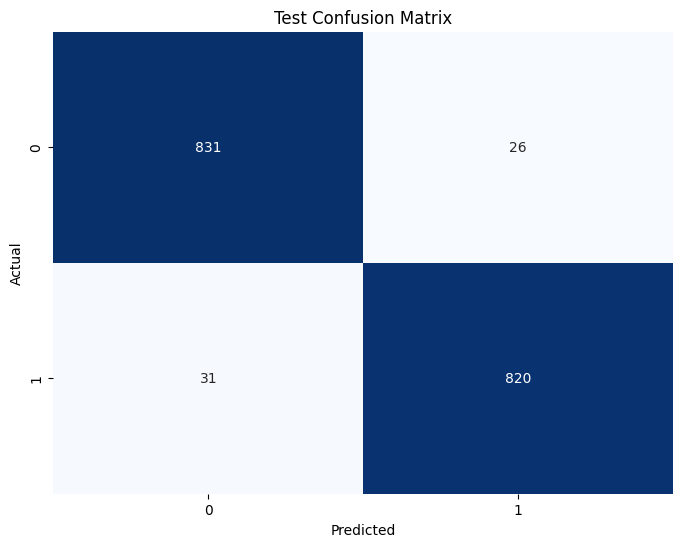

In [ ]:
# Test Score
LGB_final_test_pred = LGB_final.predict(X_test_combined)


print("Classification Report:")
print(classification_report(y_test, LGB_final_test_pred))


print("Confusion Matrix:")
cm = confusion_matrix(y_test, LGB_final_test_pred)
print(cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
selected_features = X_train_combined.columns
selected_importances = LGB_final.feature_importances_
print(f"Selected Features are: {selected_features}")
print(f"Number of Features Selected: {len(selected_features)}")

Selected Features are: Index(['length_hostname', 'nb_dots', 'nb_hyphens', 'nb_qm', 'nb_underscore',
       'nb_percent', 'nb_slash', 'nb_www', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'nb_redirection', 'char_repeat',
       'shortest_words_raw', 'shortest_word_host', 'shortest_word_path',
       'longest_words_raw', 'longest_word_host', 'avg_words_raw',
       'avg_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks',
       'ratio_extHyperlinks', 'nb_extCSS', 'ratio_extRedirection',
       'ratio_extErrors', 'links_in_tags', 'ratio_intMedia', 'ratio_extMedia',
       'safe_anchor', 'domain_in_title', 'domain_with_copyright',
       'domain_registration_length', 'domain_age', 'web_traffic',
       'google_index', 'page_rank'],
      dtype='object')
Number of Features Selected: 38


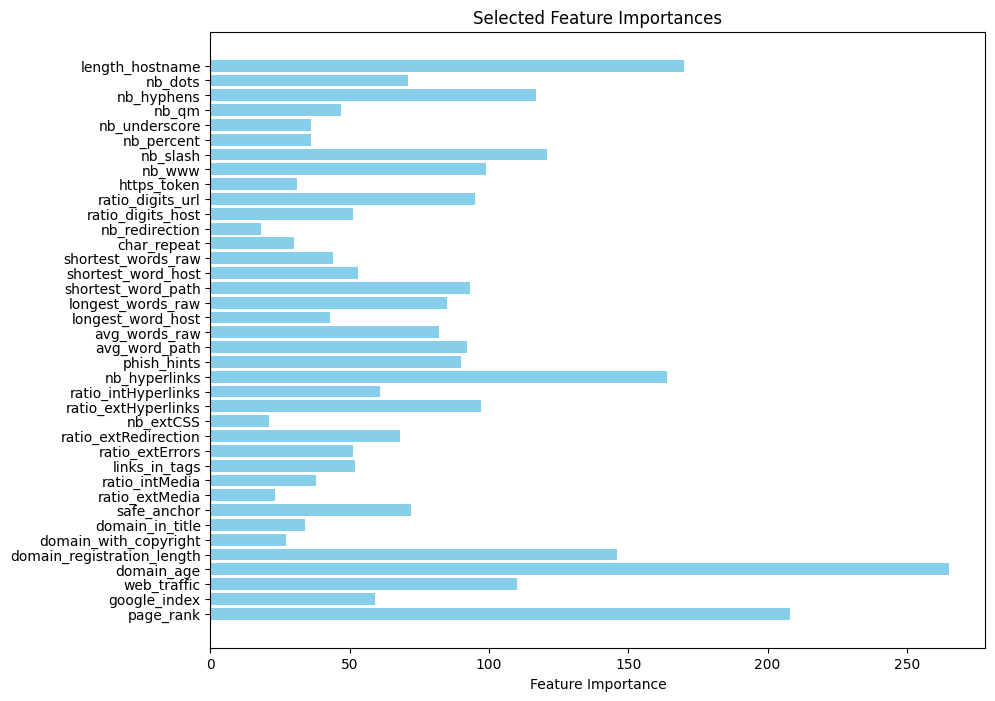

In [ ]:
plt.figure(figsize=(10, 8))
plt.barh(selected_features, selected_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

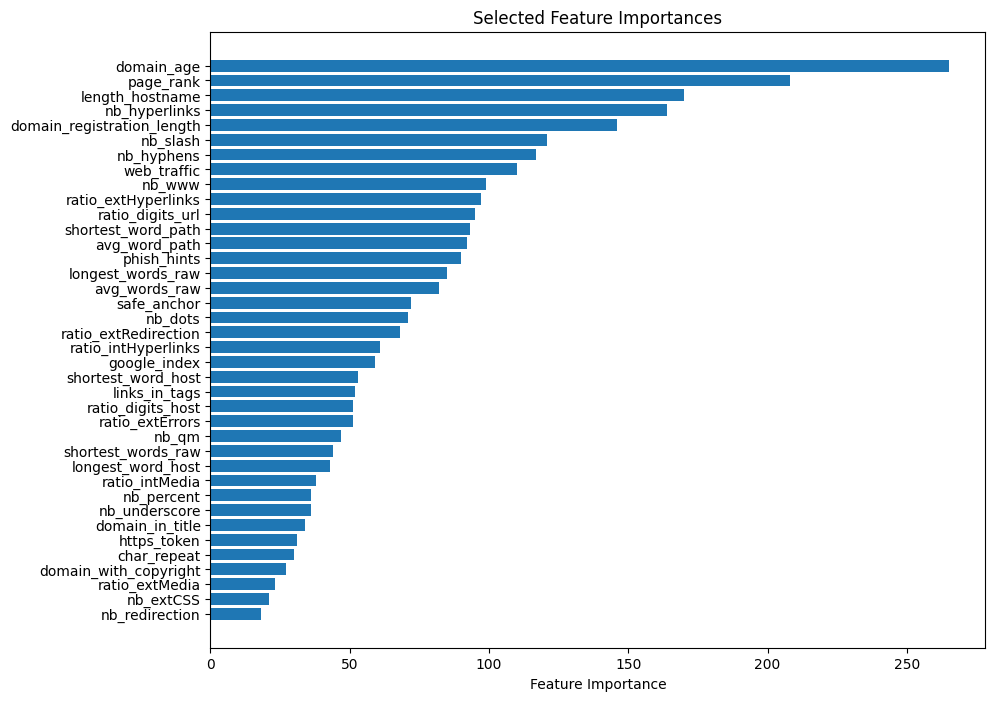

In [ ]:
sorted_indices = np.argsort(selected_importances)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_importances = selected_importances[sorted_indices]

plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.title("Selected Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
sorted_features

Index(['domain_age', 'page_rank', 'length_hostname', 'nb_hyperlinks',
       'domain_registration_length'],
      dtype='object')